# Statistical analysis of Line Task 2014 data

**20151112**

Author: Seb James <seb.james@sheffield.ac.uk>

This is a companion analysis notebook for the paper *Target-distractor Synchrony Affects Performance in a Novel Motor Task for Studying Action Selection*

## Data import

Import latency and error data which is computed from the raw data by
the script lt_analyse_all.m. This script saves the resulting data into
a Matlab v7 file.

See the Analysing Data.ipynb notebook for details about how the data
is organised. This notebook contains just the analysis.

This script requires the python modules scipy and statsmodels. It also
makes external system calls to evaluate R scripts and so R must also
be installed together with the R modules effsize and nlme. 


In [1]:
# Import the data, which should be available in Matlab v7 format. 
# fnames is used throughout the rest of this notebook, so this section needs to be evaluated!
import scipy.io as sio
mat_workspace = sio.loadmat('AllData/fnames.mat')
fnames = mat_workspace['fnames']
print 'fnames.mat has been imported.'
# We need Image from IPython.display to view graphs
from IPython.display import Image


fnames.mat has been imported.


### On subject omission

Omitted subjects, with reasons:

EM1, KW, JD, LC, YC - Experimenter chose the wrong jump time on one or
more conditions.

AB2_ - Experimenter did not carry out a Synchronous Distractor trial

is132 - Age not recorded for this participant - could not match data
to participant in Spreadsheet.

After omitting these subjects, 55 remained.

### On event omission

The script lt_analyse_latency.m will try to produce accurate latencies
to first movement, along with direction errors from the time series
data in the 2014*.txt files. It omits some events for a set of reasons
which are described in the paper (grep for omit_reason in the .m code
to find them and see the omit_reasons() function in the analysis code below).

Later, when the individual analysis is called, a standard approach to
outlier removal is taken (see individual.excludeOutliers()).

## Count the number of target events

This next section of code tallies up the number of target events in
each task. This is *not* the number of latency measurements obtained
from the data by the Octave pre-processing script.


In [21]:
from __future__ import division
import numpy as np

# Find event counts
import scipy.io as sio
mat_workspace2 = sio.loadmat('AllData/eventcounts.mat')
evcounts = mat_workspace2['fnames']

num_targs = []
nd_num_targs = []
sd_num_targs = []
ad_num_targs = []
min_nd_num_targ = 1000
min_sd_num_targ = 1000
min_ad_num_targ = 1000
min_nd_num_targ_idx = ''
min_sd_num_targ_idx = ''
min_ad_num_targ_idx = ''
max_nd_num_targ = 0
max_sd_num_targ = 0
max_ad_num_targ = 0
max_nd_num_targ_idx = ''
max_sd_num_targ_idx = ''
max_ad_num_targ_idx = ''

allevents = dict()

# Note: This code written before individual.num_target_events() and friends were implemented.
for task in zip(*evcounts):
    
    num_targ = task[1][0][0]
    cond = task[2][0]
    subj = task[0][0].split('/',2)[1]
    #print 'Subj',subj,'Num target events:',num_targ, 'Condition:',cond
    
    if cond == "No Distractor":
        nd_num_targs = np.append(nd_num_targs, num_targ)
        allevents[subj+"nd"] = num_targ
        if num_targ < min_nd_num_targ:
            min_nd_num_targ = num_targ
            min_nd_num_targ_idx = task[0][0]
        if num_targ > max_nd_num_targ:
            max_nd_num_targ = num_targ
            max_nd_num_targ_idx = task[0][0]
    elif cond == "Synchronous Distractor":
        sd_num_targs = np.append(sd_num_targs, num_targ)
        allevents[subj+"sd"] = num_targ
        if num_targ < min_sd_num_targ:
            min_sd_num_targ = num_targ
            min_sd_num_targ_idx = task[0][0]
        if num_targ > max_sd_num_targ:
            max_sd_num_targ = num_targ
            max_sd_num_targ_idx = task[0][0]
    elif cond == "Asynchronous Distractor":
        ad_num_targs = np.append(ad_num_targs, num_targ)
        allevents[subj+"ad"] = num_targ
        if num_targ < min_ad_num_targ:
            min_ad_num_targ = num_targ
            min_ad_num_targ_idx = task[0][0]
        if num_targ > max_ad_num_targ:
            max_ad_num_targ = num_targ
            max_ad_num_targ_idx = task[0][0]
    num_targs = np.append(num_targs, num_targ)
        
print 'Mean number of target events:'
print 'Overall:',num_targs.mean(),'(',num_targs.std(),')', 'ND:',nd_num_targs.mean() ,'SD:',sd_num_targs.mean() ,'AD:',ad_num_targs.mean()
print 'Min nums:'
print 'ND:',min_nd_num_targ,min_nd_num_targ_idx,'SD:',min_sd_num_targ,min_sd_num_targ_idx,'AD',min_ad_num_targ,min_ad_num_targ_idx
print 'Max nums:'
print 'ND:',max_nd_num_targ,max_nd_num_targ_idx,'SD:',max_sd_num_targ,max_sd_num_targ_idx,'AD',max_ad_num_targ,max_ad_num_targ_idx

Mean number of target events:
Overall: 64.703030303 ( 6.8721874621 ) ND: 65.5636363636 SD: 64.8545454545 AD: 63.6909090909
Min nums:
ND: 56.0 Aizat/EB1/line/20141204160911.txt SD: 42.0 Katie/JS/line/20141117163927.txt AD 37.0 Rachel/AW1_/line/20141118163209.txt
Max nums:
ND: 75.0 Rachel/AW1_/line/20141118163434.txt SD: 75.0 Rachel/EB2/line/20141118165737.txt AD 73.0 Jon/SY/line/20141125154012.txt


## Analysis code

The following code block provides a number of global functions and a
class which are used in the rest of this analysis. It's the majority
of the code used in the analysis here.

The class called *individual* stores the latency data for each
individual and has a set of methods for analysing the data.

In [8]:
from __future__ import division

import numpy as np
import random

def getfnameid (filename):
    # idarr[1] is the ID, idarr[0] is the experimenter, idarr[3] is the dated filename.
    idarr = filename.split('/')
    return idarr[1]

# From the condition string, return an index for the condition. 0 is 
# "No Distractor trial", 1 is "Synchronous Distractor trail", 2 is
# "Asynchronous Distractor trial".
def getcondition (condition_string):
    condition_index = -1
    if 'No Dist' in condition_string:
        condition_index = 0
    elif 'Synchro' in condition_string:
        condition_index = 1
    elif 'Asynchr' in condition_string:
        condition_index = 2
    return condition_index

# A Single Factor ANOVA calculation for three datasets
def group_anova(nodist_latencies,sync_latencies,async_latencies):

    all_latencies = np.concatenate((nodist_latencies, sync_latencies, async_latencies))
        
    # Compute grand mean
    grand_mean = all_latencies.mean()
    #print 'Grand mean:',grand_mean,'(',all_latencies.var(ddof=1),') not ',all_latencies.var(ddof=0)
        
    # Compute within-group variance
    tmp1 = all_latencies
    np.power(tmp1, 2)
    within_group_dof = all_latencies.size-3
    within_group_variance = tmp1.sum()/within_group_dof
    #print 'within_group_variance',within_group_variance
    
    nodist_mean = nodist_latencies.mean()
    sync_mean = sync_latencies.mean()
    async_mean = async_latencies.mean()
    
    # Compute amoung-group variance
    tmp1 = np.power (grand_mean - nodist_mean, 2)*nodist_latencies.size
    tmp2 = np.power (grand_mean - sync_mean, 2)*sync_latencies.size
    tmp3 = np.power (grand_mean - async_mean, 2)*async_latencies.size
    sosquares = tmp1 + tmp2 + tmp3
    between_group_dof = 2 # 3 conditions => 3 groups, so 3-1 DOF
    between_group_variance = sosquares / between_group_dof
    #print 'between_group_variance',between_group_variance
        
    # Now compute the F ratio
    F = between_group_variance/within_group_variance
        
    # Lastly, what's the probability for this?
    P = 1-special.fdtr(between_group_dof,within_group_dof,F)
        
    return (F, between_group_dof, within_group_dof, P)

# Convert an omit reason id to a reason string
def omit_reason (or_id):
    reason_str = ""
    if or_id == 0:
        reason_str = "0 not omitted"
    if or_id == 1:
        reason_str = "1 target posn change insignificant"
    elif or_id == 2:
        reason_str = "2 target posn held less than min. duration"
    elif or_id == 3:
        reason_str = "3 target posn change less than min. jump size"
    elif or_id == 4:
        reason_str = "4 Stable position later than event onset"
    elif or_id == 5:
        reason_str = "5 Another event caused this movement"
    elif or_id == 6:
        reason_str = "6 Not distracted"
    elif or_id == 7:
        reason_str = "7 Too fast (targ)" # faster than A.fastest_brain_decision
    elif or_id == 8:
        reason_str = "8 Too fast (distractor)" # faster than A.fastest_brain_decision
    elif or_id == 9:
        reason_str = "9 No movement detected"
    elif or_id == 10:
        reason_str = "10 Failed to find stable stylus posn"
    elif or_id == 11:
        reason_str = "11 Stable stylus period too short"
    elif or_id == 12:
        reason_str = "12 Drift too great during stable stylus period"
    elif or_id == 13:
        reason_str = "13 Drift too great during stable period (avg)"
    elif or_id == 14:
        reason_str = "14 Stylus moving at event onset"
    elif or_id == 15:
        reason_str = "15 Stylus didn't move away from target"
    elif or_id == 16:
        reason_str = "16 Movement occurs beyond next target"
    elif or_id == 17:
        reason_str = "17 Subject was distracted by closely previous distractor"
    elif or_id == 18:
        reason_str = "18 Incorrect move was recorded in previous distractor event"
    elif or_id == 19:
        reason_str = "19 This distractor event did not distract the stylus movement"
    elif or_id == 20:
        reason_str = "20 Recorded this stylus movement as a distraction towards the next distractor"

    return reason_str

# Take n sub-samples from distn
def subsample (distn, n):
    distn_cp = distn
    np.random.seed(19742016)
    counter = 0
    subsamp = []
    if n > len(distn_cp):
        print 'No possible to get',n,'samples from this distribution!'
        return subsamp
    while counter < n:
        i = 0
        for s in distn_cp:
            if np.random.uniform()>0.5:
                np.delete(distn_cp, i)
                i -= 1
                subsamp = np.append(subsamp, s)
                counter = counter + 1
            if counter >= n:
                break
            i += 1
    return subsamp

def compute_mad_outliers (points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    # Compute root mean square deviation from median:
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    # The median of this is the median abs. deviation from the median.
    med_abs_deviation = np.median(diff)
    # A modified Z score is analogous to the Z score for number of SDs from the mean.
    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def compute_mad (points):
    """
    Returns the median abs deviation value for the points

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations

    Returns:
    --------
        med_abs_deviation: The median absolute deviation

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    # Compute root mean square deviation from median:
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    # The median of this is the median abs. deviation from the median.
    med_abs_deviation = np.median(diff)
    return med_abs_deviation

# Libs used in class individual
from scipy import special
from scipy import stats
import statsmodels.api as sm
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

# A class for an individual's data.
class individual:
    def __init__(self, subj_id):

        # Hindsight note: I should have made an "event" class.
        
        self.subj_id = subj_id;
        self.idnum = -1
        self.filename = ""

        # Default number of subsamples to take from a distribution
        self.numSubsamples = 20

        # All data, errorred and ok, for each condition.
        self.alldata_nd = np.ndarray(0)
        self.alldata_sd = np.ndarray(0)
        self.alldata_ad = np.ndarray(0)
        
        # These are the "non-movement-error target latencies"
        self.nodist_latencies = np.ndarray(0)
        self.sync_latencies = np.ndarray(0)
        self.async_latencies = np.ndarray(0)
        self.nodist_latencies_rank = np.ndarray(0)
        self.sync_latencies_rank = np.ndarray(0)
        self.async_latencies_rank = np.ndarray(0)

        # These are the "non-movement-error distractor latencies"
        self.nodist_dgood_latencies = np.ndarray(0)
        self.sync_dgood_latencies = np.ndarray(0)
        self.async_dgood_latencies = np.ndarray(0)
        self.nodist_dgood_latencies_rank = np.ndarray(0)
        self.sync_dgood_latencies_rank = np.ndarray(0)
        self.async_dgood_latencies_rank = np.ndarray(0)

        # These are the "target event error latencies"
        self.nodist_err_latencies = np.ndarray(0)
        self.sync_err_latencies = np.ndarray(0)
        self.async_err_latencies = np.ndarray(0)
        self.nodist_err_latencies_rank = np.ndarray(0)
        self.sync_err_latencies_rank = np.ndarray(0)
        self.async_err_latencies_rank = np.ndarray(0)

        # These are the "distractor event error latencies" (N/A for ND or for Sync, where target==distractor event)
        self.nodist_derr_latencies = np.ndarray(0)
        self.sync_derr_latencies = np.ndarray(0)
        self.async_derr_latencies = np.ndarray(0)
        self.nodist_derr_latencies_rank = np.ndarray(0)
        self.sync_derr_latencies_rank = np.ndarray(0)
        self.async_derr_latencies_rank = np.ndarray(0)

        self.async_derr_timesince = np.ndarray(0)
        self.async_tnoerr_timesince = np.ndarray(0)
        
        self.nodist_dirns = np.ndarray(0)
        self.sync_dirns = np.ndarray(0)
        self.async_dirns = np.ndarray(0)

        self.n_errors_per_target_nd = 0
        self.n_errors_per_distractor_sync = 0
        self.n_errors_per_distractor_async = 0

        # Number of distractor events in the asynchronous case
        self.n_async_distractors = 0
        
        # Some constants
        self.DIST_EVENT = 0
        self.TARG_EVENT = 1

    def csvheader(self):
        hl = 'Experimenter,Subject,Distractor type,RT (M),RT (SD),N correct,RT incorrect (M),'
        hl += 'RT incorrect (SD),N incorrect,Error rate,D1 (-ve=>error)'
        for i in range(2,65):
            hl += ',D{0}'.format(i)
        hl += '\n'
        return hl

    def ad_omit_reasons (self, event_type):
        event_indices = [i for i,elem in enumerate(self.alldata_ad[:,1]) if elem == event_type]
        # Last col gives omit reason
        return np.bincount(self.alldata_ad[event_indices,6].astype(int),minlength=21)

    def sd_omit_reasons (self, event_type):
        event_indices = [i for i,elem in enumerate(self.alldata_sd[:,1]) if elem == event_type]
        # Last col gives omit reason
        return np.bincount(self.alldata_sd[event_indices,6].astype(int),minlength=21)

    def nd_omit_reasons (self, event_type):
        event_indices = [i for i,elem in enumerate(self.alldata_nd[:,1]) if elem == event_type]
        # Last col gives omit reason
        return np.bincount(self.alldata_nd[event_indices,6].astype(int),minlength=21)

    # Experimenter,Subject,Distractor type,RT (M),RT (SD),N correct,RT incorrect (M),
    # RT incorrect (SD),N incorrect,Error rate,Delays (negative = incorrect)
    def csvlineset(self):
        line = self.filename_nd + ',' + self.subj_id + ',0,'
        # ND mean/SD. NB: /1000 to output numbers as seconds, like Mauro reports.
        line += '{0},{1},'.format(self.nodist_mean()/1000,self.nodist_latencies.std()/1000)
        # ND RT incorrect mean/SD
        line += '{0},{1},{2},'.format(self.num_tgood(0),self.nodist_err_mean()/1000,self.nodist_err_std()/1000)
        # ND num incorrect, error rate
        line += '{0},{1}'.format(self.num_tmoveerrors(0),ind.num_tmoveerrors_percent(0))
        # ND delays
        #for i in self.nodist_latencies[:,1]:
        #    line += ',{0}'.format(i/1000)
        for i in self.alldata_nd:
            if i[5]==1:
                line += ',OR{0}'.format(omit_reason(i[6]))
            else:
                if i[2]==0: # ND and no error
                    line += ',{0}'.format(i[4]/1000)
                elif i[2]==1: # ND and error
                    # make errorred ones -ve as Mauro does.
                    line += ',{0}'.format(-i[4]/1000)
                    
        line += '\n'

        line += self.filename_sd + ',' + self.subj_id + ',1,'
        # SD mean/SD
        line += '{0},{1},'.format(self.sync_mean()/1000,self.sync_latencies.std()/1000)
        # SD RT incorrect mean/SD
        line += '{0},{1},{2},'.format(self.num_tgood(1),self.sync_err_mean()/1000,self.sync_err_std()/1000)
        # SD num incorrect, error rate
        line += '{0},{1}'.format(self.num_tmoveerrors(1),ind.num_tmoveerrors_percent(1))
        # SD delays
        for i in self.alldata_sd:
            if i[5]==1:
                line += ',OR{0}'.format(omit_reason(i[6]))
            else:
                if i[2]==0: # SD and no error
                    line += ',{0}'.format(i[4]/1000)
                elif i[2]==1: # SD and error
                    # make errorred ones -ve as Mauro does.
                    line += ',{0}'.format(-i[4]/1000)
        line += '\n'

        line += self.filename_ad + ',' + self.subj_id + ',2,'
        # AD mean/SD
        line += '{0},{1},'.format(self.async_latencies.mean()/1000,self.async_latencies.std()/1000)
        # AD RT incorrect mean/SD
        line += '{0},{1},{2},'.format(self.num_tgood(2),self.async_err_mean()/1000,self.async_err_std()/1000)
        # AD num incorrect, error rate
        line += '{0},{1}'.format(self.num_tmoveerrors(2),ind.num_tmoveerrors_percent(2))
        # AD delays
        for i in self.alldata_ad:
            if i[5]==1:
                line += ',OR{0}'.format(omit_reason(i[6]))
            else:
                if i[1]==1 and i[2]==0: # TARG_EVENT and AD and no error
                    line += ',{0}'.format(i[4]/1000)
                elif i[1]==1 and i[2]==1: # TARG_EVENT and AD and error
                    # make errorred ones -ve as Mauro does.
                    line += ',{0}'.format(-i[4]/1000)
        line += '\n'

        return line

    # Compute ANOVA for this individual
    def anova(self):
        F, between_group_dof, within_group_dof, P = group_anova (self.nodist_latencies[:,1], self.sync_latencies[:,1], self.async_latencies[:,1])
        return (F, between_group_dof, within_group_dof, P)

    def reportmeans (self):
        print "Mean(SD): No distr: {0:.2f} ({1:.2f}) Sync: {2:.2f} ({3:.2f}) Async: {4:.2f} ({5:.2f})".format(self.nodist_mean(), self.nodist_std(), self.sync_mean(), self.sync_std(), self.async_mean(), self.async_std())

    # Batch up all data in a form suitable for statsmodel's MultiComparison class. This means
    # concatenating the ND, SD & AD data intoa single array, and making a "label" array to match.
    def getMultiComparisonData (self):
        d = np.hstack((self.nodist_latencies[:,1],self.sync_latencies[:,1],self.async_latencies[:,1]))

        nd_labels = np.ndarray(shape=(self.num_tgood(0),), dtype=object)
        nd_labels.fill('ND')

        sd_labels = np.ndarray(shape=(self.num_tgood(1),), dtype=object)
        sd_labels.fill('SD')

        ad_labels = np.ndarray(shape=(self.num_tgood(2),), dtype=object)
        ad_labels.fill('AD')

        l = np.hstack((nd_labels,sd_labels,ad_labels))

        # d is the data array, l is the label array.
        return (d, l)

    # Do a full set of graphs to show the normality of the data. Show QQ plots,
    # histograms of the distributions and results of Shapiro-Wilks tests for comparison.
    # Pass in the significance level for the S-W test.
    def shownormality (self, alpha):
        f, axarr = plt.subplots(3, 2)

        #ax1.set_title('QQ plots')
        fig1 = sm.qqplot(self.nodist_latencies[:,1], fit=True, line='45',ax=axarr[0,0])
        fig2 = sm.qqplot(self.sync_latencies[:,1], fit=True, line='45',ax=axarr[1,0])
        fig3 = sm.qqplot(self.async_latencies[:,1], fit=True, line='45', ax=axarr[2,0])
        axarr[0,0].set_title('QQ Plots')

        W, p = stats.shapiro (subsample(self.nodist_latencies[:,1], self.numSubsamples))
        isNormal = False
        if p > alpha:
            isNormal = True
        sw = 'ND. Mean/SD:{2:.2f}/{3:.2f} W={0:.2f}, p={1:.2f} (Normal:{4})'.format(W,p,self.nodist_mean(),self.nodist_std(),isNormal)
        axarr[0,1].hist(self.nodist_latencies[:,1], bins=20, label=sw)
        axarr[0,1].legend(prop={'size':9})
        axarr[0,1].set_title('Dist\'ns with Shapiro-Wilks stats')

        W, p = stats.shapiro (subsample(self.sync_latencies[:,1], self.numSubsamples))
        isNormal = False
        if p > alpha:
            isNormal = True
        sw = 'SD. Mean/SD:{2:.2f}/{3:.2f} W={0:.2f}, p={1:.2f} (Normal:{4})'.format(W,p,self.sync_mean(),self.sync_std(),isNormal)
        axarr[1,1].hist(self.sync_latencies[:,1], bins=20, label=sw)
        axarr[1,1].legend(prop={'size':9})

        W, p = stats.shapiro (subsample(self.async_latencies[:,1], self.numSubsamples))
        isNormal = False
        if p > alpha:
            isNormal = True
        sw = 'AD. Mean/SD:{2:.2f}/{3:.2f} W={0:.2f}, p={1:.2f} (Normal:{4})'.format(W,p,self.async_mean(),self.async_std(),isNormal)
        axarr[2,1].hist(self.async_latencies[:,1], bins=20, label=sw)
        axarr[2,1].legend(prop={'size':9})

        # Fine-tune figure; make subplots close to each other and hide x ticks for
        # all but bottom plot.
        f.subplots_adjust(hspace=0)
        plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

        savename = 'images/' + self.subj_id + 'normplot.png'
        plt.savefig(savename)
        plt.show()
        
    # Apply Shapiro-Wilk test. Null hypothesis is that the data are normally
    # distributed. If p < alpha then null hypothesis must be rejected and data
    # cannot be considered to be normally distributed.
    def shapiroWilk (self, condition, alpha):

        W = -1
        p = -1
        isNormal = False

        if condition == 0:
            W, p = stats.shapiro (subsample(self.nodist_latencies[:,1], self.numSubsamples))
        elif condition == 1:
            ss = subsample(self.sync_latencies[:,1], self.numSubsamples)
            W, p = stats.shapiro (ss)
        elif condition == 2:
            W, p = stats.shapiro (subsample(self.async_latencies[:,1], self.numSubsamples))
        # else leave W,p,isNormal with default values

        if p > alpha:
            isNormal = True

        return W, p, isNormal

    # Do a Quantile-Quantile plot to compare against normal distribution
    def qqplot (self):
        f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
        ax1.set_title('QQ plots',fontsize=18)
        fig1 = sm.qqplot(self.nodist_latencies[:,1], fit=True, line='45',ax=ax1)
        fig2 = sm.qqplot(self.sync_latencies[:,1], fit=True, line='45',ax=ax2)
        fig3 = sm.qqplot(self.async_latencies[:,1], fit=True, line='45', ax=ax3)
        # Fine-tune figure; make subplots close to each other and hide x ticks for
        # all but bottom plot.
        f.subplots_adjust(hspace=0)
        plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False, fontsize=18)
        plt.show()
        return f

    def boxplot (self):
        data = [self.nodist_latencies[:,1], self.sync_latencies[:,1], self.async_latencies[:,1]]
        plt.figure()
        plt.boxplot(data, 0, 'gD')
        nodist_cond_x = np.ones(self.nodist_latencies[:,1].size)-0.1
        sync_cond_x = 2*np.ones(self.sync_latencies[:,1].size)-0.1
        async_cond_x = 3*np.ones(self.async_latencies[:,1].size)-0.1
        nodist_pts = plt.scatter(nodist_cond_x, self.nodist_latencies[:,1])
        sync_pts = plt.scatter(sync_cond_x, self.sync_latencies[:,1])
        async_pts = plt.scatter(async_cond_x, self.async_latencies[:,1])
        plt.xlabel('Condition 1:ND 2:S 3:AS',fontsize=18)
        plt.ylabel('Latency (ms)',fontsize=18)
        savename = 'images/' + self.subj_id + 'boxplot.png'
        plt.savefig(savename)
        plt.show()

    # A standard method for excluding outliers
    def excludeOutliers (self, show_excluded=0):
        # Exclude from latency data
        if show_excluded:
            print 'Excluding good movement outliers...'
        self.excludeOutliers_mad_based(3.5,show_excluded)
        # Exclude from error data:
        if show_excluded:
            print 'Excluding error outliers...'
        self.excludeErrOutliers(3.5,show_excluded)# also mad based

    # subroutine of excludeOutliers_mad_based()
    def excludeOutliers_mad_based_(self, latencies, alldata, thresh, show_excluded=0):
        nd_outliers = compute_mad_outliers (latencies,thresh)
        # nd_outliers is a large array of True/False.
        # print 'nd_outliers:',nd_outliers
        del_indices = [i for i,elem in enumerate(nd_outliers) if elem == True]
        # del_indices are the indices of the True values in nd_outliers
        if not del_indices:
            return latencies,alldata
        
        # The event number is not the same as the index into latencies
        event_indices = latencies[[del_indices]][:,0]

        if show_excluded:
            values_to_delete = latencies[[del_indices]][:,1]
            print 'deleting the following events',event_indices,'which have values',values_to_delete
        
        keepmask_bool = np.invert(np.in1d(latencies[:,0], event_indices, assume_unique=True))
        latencies = latencies[keepmask_bool]
        # Remove same indices from self.alldata:
        keepmask_bool = np.invert(np.in1d(alldata[:,0], event_indices, assume_unique=True))
        alldata = alldata[keepmask_bool]
        return latencies,alldata

    # Exclude outliers from each latency set based on median absolute deviation method.
    def excludeOutliers_mad_based(self, thresh=3.5, show_excluded=0):
        if show_excluded:
            print 'exclude nodist latencies for subject ',self.subj_id,'filename',self.filename_nd
        self.nodist_latencies,self.alldata_nd = self.excludeOutliers_mad_based_(self.nodist_latencies,self.alldata_nd,thresh,show_excluded)
        if show_excluded:
            print 'exclude sync latencies for subject ',self.subj_id,'filename',self.filename_sd
        self.sync_latencies,self.alldata_sd = self.excludeOutliers_mad_based_(self.sync_latencies,self.alldata_sd,thresh,show_excluded)
        if show_excluded:
            print 'exclude async latencies for subject ',self.subj_id,'filename',self.filename_ad
        self.async_latencies,self.alldata_ad = self.excludeOutliers_mad_based_(self.async_latencies,self.alldata_ad,thresh,show_excluded)

    def excludeErrOutliers (self, num_sds, show_excluded):
        if show_excluded:
            print 'exclude nodist latencies for subject ',self.subj_id,'filename',self.filename_nd
        self.nodist_err_latencies,self.alldata_nd = self.excludeOutliers_mad_based_(self.nodist_err_latencies,self.alldata_nd,num_sds,show_excluded)
        if show_excluded:
            print 'exclude sync latencies for subject ',self.subj_id,'filename',self.filename_sd
        self.sync_err_latencies,self.alldata_sd = self.excludeOutliers_mad_based_(self.sync_err_latencies,self.alldata_sd,num_sds,show_excluded)
        if show_excluded:
            print 'exclude async latencies for subject ',self.subj_id,'filename',self.filename_ad
        self.async_err_latencies,self.alldata_ad = self.excludeOutliers_mad_based_(self.async_err_latencies,self.alldata_ad,num_sds,show_excluded)

    def randomly_subsample_data (self, num_data):
        random.seed(19742016)
        while len(self.nodist_latencies[:,1]) > num_data:
            remove_this = random.randint (0,len(self.nodist_latencies[:,1])-1)
            self.nodist_latencies = np.delete(self.nodist_latencies, remove_this, axis=0)
        while len(self.sync_latencies[:,1]) > num_data:
            remove_this = random.randint (0,len(self.sync_latencies[:,1])-1)
            self.sync_latencies = np.delete(self.sync_latencies, remove_this, axis=0)
        while len(self.async_latencies[:,1]) > num_data:
            remove_this = random.randint (0,len(self.async_latencies[:,1])-1)
            self.async_latencies = np.delete(self.async_latencies, remove_this, axis=0)

    def graph1(self):
        print 'Showing graph for ', ind.subj_id
        means = (self.nodist_mean(), self.sync_mean(), self.async_mean())
        stds = (self.nodist_std(), self.sync_std(), self.async_std())
        index = np.arange(3)
        opacity = 0.4
        error_config = {'ecolor': '0.3'}
        rects1 = plt.bar(index, means, 0.2,
                 alpha=opacity,
                 color='b',
                 yerr=stds,
                 error_kw=error_config,
                 label=ind.subj_id)
        # Now draw the points on a scatter graph
        nodist_cond_x = np.zeros(self.nodist_latencies[:,1].size)
        sync_cond_x = np.ones(self.sync_latencies[:,1].size)
        async_cond_x = 2*np.ones(self.async_latencies[:,1].size)
        nodist_pts = plt.scatter(nodist_cond_x, self.nodist_latencies)
        sync_pts = plt.scatter(sync_cond_x, self.sync_latencies)
        async_pts = plt.scatter(async_cond_x, self.async_latencies)
        plt.xlabel('Condition 0:ND 1:S 2:AS')
        plt.ylabel('Latency (ms)')
        plt.title(self.subj_id)
        plt.show()
        return

    # Compute the sum of the squared displacements from the mean for all three conditions
    def sumofsquare_displacements_all_from_value(self, value):
        sos = self.sumofsquare_displacements_from_value(0,value) + self.sumofsquare_displacements_from_value(1,value) + self.sumofsquare_displacements_from_value(2,value)
        return sos

    # Compute the sum of the squared displacements from the mean for all three conditions
    def sumofsquare_displacements_all(self):
        sos = self.sumofsquare_displacements(0) + self.sumofsquare_displacements(1) + self.sumofsquare_displacements(2)
        return sos

    # Compute the sum of the squared displacements from the mean for the given condition
    def sumofsquare_displacements(self, condition):
        if condition == 0:
            mn = self.nodist_mean()
            squares = np.power((self.nodist_latencies[:,1] - mn), 2)
        elif condition == 1:
            mn = self.sync_mean()
            squares = np.power((self.sync_latencies[:,1] - mn), 2)
        else: # condition 2
            mn = self.async_mean()
            squares = np.power((self.async_latencies[:,1] - mn), 2)
        sos = np.sum(squares)
        return sos

    # Compute the sum of the squared displacements from the mean for the given condition
    def sumofsquare_displacements_from_value(self, condition, value):
        if condition == 0:
            squares = np.power((self.nodist_latencies[:,1] - value), 2)
            # Verification of this method:
            #squares_alt = 0
            #for i in self.nodist_latencies:
            #    imv = i - value
            #    squares_alt += imv*imv
            #print 'nd sum of squares:',np.sum(squares),'squares_alt:',squares_alt
        elif condition == 1:
            squares = np.power((self.sync_latencies[:,1] - value), 2)
        else: # condition 2
            squares = np.power((self.async_latencies[:,1] - value), 2)
        sos = np.sum(squares)
        return sos

    def alldata_for_condition(self, condition):
        if condition == 0:
            thedata = self.alldata_nd
        elif condition == 1:
            thedata = self.alldata_sd
        else: # condition 2
            thedata = self.alldata_ad
        return thedata

    def num_target_omissions(self, condition):
        thedata = self.alldata_for_condition(condition)
        # Select rows for which omit==1:
        omit_indices = [i for i,elem in enumerate(thedata[:,5]) if elem == 1]
        num_omit = 0
        if omit_indices:
            # From those rows, select those for which event type is target (1)
            omit_target_indices = [i for i,elem in enumerate(thedata[omit_indices,1]) if elem == 1]
            if omit_target_indices:
                num_omit = thedata[[omit_target_indices]][:,4].size

        return num_omit

    def num_target_non_omissions(self, condition):
        thedata = self.alldata_for_condition(condition)
        # Select rows for which omit==0:
        nomit_indices = [i for i,elem in enumerate(thedata[:,5]) if elem == 0]
        num_nomit = 0
        if nomit_indices:
            # From those rows, select those for which event type is target (1)
            nomit_target_indices = [i for i,elem in enumerate(thedata[nomit_indices,1]) if elem == 1]
            if nomit_target_indices:
                num_nomit = thedata[[nomit_target_indices]][:,4].size

        return num_nomit

    def num_distractor_events(self, condition):

        # In ND case, num_distractor_events == 0 by definition
        num = 0
        if condition == 0:
            return num

        # In SD case, num_distractor_events == num_target_events
        if condition == 1:
            return self.num_target_events(condition)

        thedata = self.alldata_for_condition(condition)
        distractor_indices = [i for i,elem in enumerate(thedata[:,1]) if elem == 0]
        if distractor_indices:
            num = thedata[[distractor_indices]][:,4].size
        return num

    def num_target_events(self, condition):
        thedata = self.alldata_for_condition(condition)
        distractor_indices = [i for i,elem in enumerate(thedata[:,1]) if elem == 1]
        num = 0
        if distractor_indices:
            num = thedata[[distractor_indices]][:,4].size
        return num

    def num_distractor_omissions(self, condition):
        thedata = self.alldata_for_condition(condition)

        # Select rows for which omit==1:
        omit_indices = [i for i,elem in enumerate(thedata[:,5]) if elem == 1]
        num_omit = 0
        if omit_indices:
            # From those rows, select those for which event type is distractor (0)
            omit_distractor_indices = [i for i,elem in enumerate(thedata[omit_indices,1]) if elem == 0]
            if omit_distractor_indices:
                num_omit = thedata[[omit_distractor_indices]][:,4].size

        return num_omit

    def num_distractor_non_omissions(self, condition):
        thedata = self.alldata_for_condition(condition)

        # Select rows for which omit==0:
        nomit_indices = [i for i,elem in enumerate(thedata[:,5]) if elem == 0]
        num_nomit = 0
        if nomit_indices:
            # From those rows, select those for which event type is distractor (0)
            nomit_distractor_indices = [i for i,elem in enumerate(thedata[nomit_indices,1]) if elem == 0]
            if nomit_distractor_indices:
                num_nomit = thedata[[nomit_distractor_indices]][:,4].size

        return num_nomit

    # Movements following target events which are good and without error
    def num_tgood(self, condition):
        if condition == 0:
            if self.nodist_latencies.size<2:
                 return 0
            return self.nodist_latencies[:,1].size
        elif condition == 1:
            if self.sync_latencies.size<2:
                 return 0
            return self.sync_latencies[:,1].size
        else: # condition 2
            if self.async_latencies.size<2:
                 return 0
            return self.async_latencies[:,1].size

    def num_tgood_all(self):
        n = self.num_tgood(0) + self.num_tgood(1) + self.num_tgood(2)
        return n

    # num_tgood_percent. Number of good movements as a percentage of number of target events
    def num_tgood_percent(self, condition):
        if condition == 0:
            if self.nodist_latencies.size<2:
                 return 0
            return 100*self.nodist_latencies[:,1].size/self.num_target_events(condition)
        elif condition == 1:
            if self.sync_latencies.size<2:
                 return 0
            return 100*self.sync_latencies[:,1].size/self.num_target_events(condition)
        else: # condition 2
            if self.async_latencies.size<2:
                 return 0
            #prop_targets_non_omitted = self.num_target_non_omissions(condition)/self.num_target_events(condition)
            #representative_num_distractors = prop_targets_non_omitted * self.num_distractor_events(condition)
            return 100*self.async_latencies[:,1].size/self.num_target_events(condition)

    # moveerrors are "errors for target movements"
    def num_tmoveerrors_all(self):
        n = self.num_tmoveerrors(0) + self.num_tmoveerrors(1) + self.num_tmoveerrors(2)
        return n

    # Number of target movement errors
    def num_tmoveerrors(self, condition):
        
        #print 'num_tmoveerrors(',condition,') called'
        if condition == 0:
            #print 'nodist_err_latencies.size:',self.nodist_err_latencies.size
            if self.nodist_err_latencies.size<2:
                #print 'Returning 0 for nodist_err_latencies:',self.nodist_err_latencies
                return 0
            elif self.nodist_err_latencies.size == 2:
                #print 'Returning 1 for nodist_err_latencies:',self.nodist_err_latencies
                return 1
            #print 'Returning [:,1].size for nodist_err_latencies'
            return self.nodist_err_latencies[:,1].size
        elif condition == 1:
            #print 'sync_err_latencies.size:',self.sync_err_latencies.size
            if self.sync_err_latencies.size<2:
                 return 0
            elif self.sync_err_latencies.size == 2:
                return 1
            return self.sync_err_latencies[:,1].size
        else: # condition 2
            #print 'async_err_latencies.size:',self.async_err_latencies.size
            if self.async_err_latencies.size<2:
                 return 0
            elif self.async_err_latencies.size == 2:
                return 1
            return self.async_err_latencies[:,1].size

    # Number of target movement errors as a percentage of number of target events
    def num_tmoveerrors_percent(self, condition):
        if condition == 0:
            if self.nodist_err_latencies.size<2:
                 return 0
            return 100*self.nodist_err_latencies[:,1].size/self.num_target_non_omissions(condition)
        elif condition == 1:
            if self.sync_err_latencies.size<2:
                 return 0
            return 100*self.sync_err_latencies[:,1].size/self.num_target_non_omissions(condition)
        else: # condition 2
            if self.async_err_latencies.size<2:
                 return 0
            return 100*self.async_err_latencies[:,1].size/self.num_target_non_omissions(condition)
    
    # dmoverrors are : Distractor move errors
    def num_dmoveerrors_all(self):
        n = self.num_dmoveerrors(0) + self.num_dmoveerrors(1) + self.num_dmoveerrors(2)
        return n

    def num_dmoveerrors(self, condition):
        if condition == 0:
            if self.nodist_derr_latencies.size<2:
                 return 0
            return self.nodist_derr_latencies[:,1].size
        elif condition == 1:
            if self.sync_derr_latencies.size<2:
                 return 0
            return self.sync_derr_latencies[:,1].size
        else: # condition 2
            if self.async_derr_latencies.size<2:
                 return 0
            return self.async_derr_latencies[:,1].size

    # number of detected distractor errors as a percentage of the
    # total number of distractor events
    def num_dmoveerrors_percent(self, condition):
        if condition == 0:
            return 0 # 0 by definition
        elif condition == 1:
            if self.sync_derr_latencies.size<2:
                 return 0
            return 100*self.sync_derr_latencies[:,1].size/self.num_distractor_events(condition)
        else: # condition 2
            if self.async_derr_latencies.size<2:
                 return 0
            return 100*self.async_derr_latencies[:,1].size/self.num_distractor_events(condition)

    # Total number of movement errors (target and distractor) as a
    # percentage of the number of target events not omitted
    def num_moveerrors_per_target_percent(self, condition):
        moveerrors_percent = 0
        if condition == 0:
            # same as num_tmoveerrors_percent:
            moveerrors_percent = self.num_tmoveerrors_percent(condition)
        elif condition == 1:
            numerr = self.num_tmoveerrors(condition)+self.num_dmoveerrors(condition)
            moveerrors_percent = 100 * numerr / self.num_target_non_omissions(condition)
        else: # condition == 2
            numerr = self.num_tmoveerrors(condition)+self.num_dmoveerrors(condition)
            moveerrors_percent = 100 * numerr / self.num_target_non_omissions(condition)
        return moveerrors_percent

    # as above, but not as a percentage
    def num_moveerrors_per_target(self, condition):
        moveerrors_ = 0
        if condition == 0 or condition == 1:
            # same as num_tmoveerrors_ for the ND and SD cases
            moveerrors_ = self.num_tmoveerrors_percent(condition)/100
        else: # condition == 2
            numerr = self.num_tmoveerrors(condition)+self.num_dmoveerrors(condition)
            moveerrors_ = numerr / self.num_target_non_omissions(condition)
        return moveerrors_

    # Total number of movement errors as a percentage of "the
    # proportion of all distractor events matching the proportion of
    # target events not omitted from latency measurement"
    def num_moveerrors_per_distractor_percent(self, condition):
        moveerrors_percent = 0
        prop_target_events = self.num_target_non_omissions(condition)/self.num_target_events(condition)
        if condition == 0:
            moveerrors_percent = -1 # nan really
        elif condition == 1:
            # For the SD condition, target moveerrors == distractor moveerrors
            moveerrors_percent = self.num_moveerrors_per_target_percent(condition)
        else: # condition == 2
            numerr = self.num_tmoveerrors(condition)+self.num_dmoveerrors(condition)
            moveerrors_percent = 100 * numerr / self.num_distractor_events(condition)*prop_target_events
        return moveerrors_percent

    # dgood : Distractor events without a move error
    def num_dgood_all(self):
        n = self.num_dgood(0) + self.num_dgood(1) + self.num_dgood(2)
        return n

    def num_dgood(self, condition):
        if condition == 0:
            if self.nodist_dgood_latencies.size<2:
                return 0
            return self.nodist_dgood_latencies[:,1].size
        elif condition == 1:
            if self.sync_dgood_latencies.size<2:
                return 0
            return self.sync_dgood_latencies[:,1].size
        else: # condition 2
            if self.async_dgood_latencies.size<2:
                return 0
            return self.async_dgood_latencies[:,1].size

    def num_dgood_percent(self, condition):
        if condition == 0:
            if self.nodist_dgood_latencies.size<2:
                return 0
            return 100*self.nodist_dgood_latencies[:,1].size/(self.num_tgood(condition)+self.num_dgood(condition)+self.num_tmoveerrors(condition)+self.num_dmoveerrors(condition))
        elif condition == 1:
            if self.sync_dgood_latencies.size<2:
                return 0
            return 100*self.sync_dgood_latencies[:,1].size/(self.num_tgood(condition)+self.num_dgood(condition)+self.num_tmoveerrors(condition)+self.num_dmoveerrors(condition))
        else: # condition 2
            if self.async_dgood_latencies.size<2:
                return 0
            return 100*self.async_dgood_latencies[:,1].size/(self.num_tgood(condition)+self.num_dgood(condition)+self.num_tmoveerrors(condition)+self.num_dmoveerrors(condition))

    def nodist_mean(self):
        if self.nodist_latencies.size<2:
            return 0
        return self.nodist_latencies[:,1].mean()

    def sync_mean(self):
        if self.sync_latencies.size<2:
            return 0
        return self.sync_latencies[:,1].mean()

    def async_mean(self):
        if self.async_latencies.size<2:
            return 0
        return self.async_latencies[:,1].mean()

    def overall_mean(self):
        all_latencies = np.concatenate((self.nodist_latencies, self.sync_latencies, self.async_latencies))
        return all_latencies[:,1].mean()

    def overall_std(self):
        all_latencies = np.concatenate((self.nodist_latencies, self.sync_latencies, self.async_latencies))
        return all_latencies[:,1].std()

    def nodist_std(self):
        if self.nodist_latencies.size<2:
            return 0
        return self.nodist_latencies[:,1].std()

    def sync_std(self):
        if self.sync_latencies.size<2:
            return 0
        return self.sync_latencies[:,1].std()

    def async_std(self):
        if self.async_latencies.size<2:
            return 0
        return self.async_latencies[:,1].std()

    # mean/std accessors for the error latencies:
    def nodist_err_mean(self):
        if self.nodist_err_latencies.size<2:
            return 0
        return self.nodist_err_latencies.mean()

    def sync_err_mean(self):
        if self.sync_err_latencies.size<2:
            return 0
        return self.sync_err_latencies.mean()

    def async_err_mean(self):
        if self.async_err_latencies.size<2:
            return 0
        return self.async_err_latencies.mean()

    def overall_err_mean(self):
        all_err_latencies = np.concatenate((self.nodist_err_latencies, self.sync_err_latencies, self.async_err_latencies))
        return all_err_latencies[:,1].mean()

    def overall_err_std(self):
        all_err_latencies = np.concatenate((self.nodist_err_latencies, self.sync_err_latencies, self.async_err_latencies))
        return all_err_latencies[:,1].std()

    def nodist_err_std(self):
        if self.nodist_err_latencies.size<2:
            return 0
        return self.nodist_err_latencies.std()

    def sync_err_std(self):
        if self.sync_err_latencies.size<2:
            return 0
        return self.sync_err_latencies.std()

    def async_err_std(self):
        if self.async_err_latencies.size<2:
            return 0
        return self.async_err_latencies.std()

    # mean/std accessors for the distractor error latencies:
    def nodist_derr_mean(self):
        if self.nodist_derr_latencies.size<2:
            return 0
        return self.nodist_derr_latencies.mean()

    def sync_derr_mean(self):
        if self.sync_derr_latencies.size<2:
            return 0
        return self.sync_derr_latencies.mean()

    def async_derr_mean(self):
        if self.async_derr_latencies.size<2:
            return 0
        return self.async_derr_latencies.mean()

    def overall_derr_mean(self):
        all_derr_latencies = np.concatenate((self.nodist_derr_latencies, self.sync_derr_latencies, self.async_derr_latencies))
        return all_derr_latencies[:,1].mean()

    def overall_derr_std(self):
        all_derr_latencies = np.concatenate((self.nodist_derr_latencies, self.sync_derr_latencies, self.async_derr_latencies))
        return all_derr_latencies[:,1].std()

    def nodist_derr_std(self):
        if self.nodist_derr_latencies.size<2:
            return 0
        return self.nodist_derr_latencies.std()

    def sync_derr_std(self):
        if self.sync_derr_latencies.size<2:
            return 0
        return self.sync_derr_latencies.std()

    def async_derr_std(self):
        if self.async_derr_latencies.size<2:
            return 0
        return self.async_derr_latencies.std()

    # mean/std accessors for the distractor non-movement-error latencies:
    def nodist_dgood_mean(self):
        if self.nodist_dgood_latencies.size<2:
            return 0
        return self.nodist_dgood_latencies.mean()

    def sync_dgood_mean(self):
        if self.sync_dgood_latencies.size<2:
            return 0
        return self.sync_dgood_latencies.mean()

    def async_dgood_mean(self):
        if self.async_dgood_latencies.size<2:
            return 0
        return self.async_dgood_latencies.mean()

    def overall_dgood_mean(self):
        all_dgood_latencies = np.concatenate((self.nodist_dgood_latencies, self.sync_dgood_latencies, self.async_dgood_latencies))
        return all_dgood_latencies[:,1].mean()

    def overall_dgood_std(self):
        all_dgood_latencies = np.concatenate((self.nodist_dgood_latencies, self.sync_dgood_latencies, self.async_dgood_latencies))
        return all_dgood_latencies[:,1].std()

    def nodist_dgood_std(self):
        if self.nodist_dgood_latencies.size<2:
            return 0
        return self.nodist_dgood_latencies.std()

    def sync_dgood_std(self):
        if self.sync_dgood_latencies.size<2:
            return 0
        return self.sync_dgood_latencies.std()

    def async_dgood_std(self):
        if self.async_dgood_latencies.size<2:
            return 0
        return self.async_dgood_latencies.std()
    
    def report_movements(self,cond):
        if cond==0:
            str = '   ND'
        elif cond==1:
            str = '   Sync'
        else:
            print 'cond=',cond
            str = '   Async'
        
        print str,'non-error target movements',ind.num_tgood(cond),'-',100*ind.num_tgood(cond)/(ind.num_tgood(cond)+ind.num_dgood(cond)+ind.num_tmoveerrors(cond)+ind.num_dmoveerrors(cond)),'%'
        print str,'non-error distractor events',ind.num_dgood(cond),'-',100*ind.num_dgood(cond)/(ind.num_tgood(cond)+ind.num_dgood(cond)+ind.num_tmoveerrors(cond)+ind.num_dmoveerrors(cond)),'%'
        print str,'target movement errors:',ind.num_tmoveerrors(cond),'-',100*ind.num_tmoveerrors(cond)/(ind.num_tgood(cond)+ind.num_dgood(cond)+ind.num_tmoveerrors(cond)+ind.num_dmoveerrors(cond)),'%'
        print str,'distractor movement errors:',ind.num_dmoveerrors(cond),'-',100*ind.num_dmoveerrors(cond)/(ind.num_tgood(cond)+ind.num_dgood(cond)+ind.num_tmoveerrors(cond)+ind.num_dmoveerrors(cond)),'%'
        print str,'total events:',ind.num_tgood(cond)+ind.num_tmoveerrors(cond)+ind.num_dmoveerrors(cond),'total errors:',ind.num_tmoveerrors(cond)+ind.num_dmoveerrors(cond)
        print ''

    def __str__(self):
        return "Data container for subject {0}".format(self.subj_id)

    # Output latency means for the three conditions as three lines for a csv file.
    def outputDataForR(self):
        # R doesn't like 'NA' in a field - it reads it as "not
        # available" so substitute "NA_" for "NA" here.
        if self.subj_id == 'NA':
            self.subj_id = 'NA_';
        line = '{2},{1},0,ND,{0}\n'.format(self.subj_id,self.nodist_latencies[:,1].mean(),self.idnum)
        line += '{2},{1},1,SD,{0}\n'.format(self.subj_id,self.sync_latencies[:,1].mean(),self.idnum)
        line += '{2},{1},2,AD,{0}\n'.format(self.subj_id,self.async_latencies[:,1].mean(),self.idnum)
        return line

    # Write out per-individual data for analysis in R into a file.
    def writeDataForR(self):
        dfname = 'IndDat' + self.subj_id + '.csv'

        theheader = "latency,condition_str\n"
        minsize = np.min([self.nodist_latencies[:,1].size,self.sync_latencies[:,1].size,self.async_latencies[:,1].size])
        _nd = subsample(self.nodist_latencies[:,1], minsize)
        _sd = subsample(self.sync_latencies[:,1], minsize)
        _ad = subsample(self.async_latencies[:,1], minsize)

        f = open(dfname, 'w')
        f.write(theheader)
        # allaltlines is the latency trials all together
        allaltlines = ''
        for i in range(1,minsize):
            line = "{0},ND\n{1},SD\n{2},AD\n".format(_nd[i],_sd[i],_ad[i])
            altline = "{3},{0},ND\n{3},{1},SD\n{3},{2},AD\n".format(_nd[i],_sd[i],_ad[i],self.subj_id,self.subj_id,self.subj_id)
            allaltlines += altline
            f.write(line)
        f.close()
        return allaltlines

    def writeNoDistDataForR(self):
        all_lines = ''
        if self.subj_id == 'NA':
            self.subj_id = 'NA_';
        theheader = "subj_id,num,type,error,correctmove,latency,omit,direction\n"
        dfname = 'NoDistDat' + self.subj_id + '.csv'
        f = open(dfname, 'w')
        f.write(theheader)
        minsize = self.alldata_nd[:,1].size
        for i in range(1,minsize):
            line = "{0},{1},{2},{3},{4},{5},{6},{7}\n".format(
                self.subj_id,
                self.alldata_nd[i,0],
                self.alldata_nd[i,1],
                self.alldata_nd[i,2],
                self.alldata_nd[i,3],
                self.alldata_nd[i,4],
                self.alldata_nd[i,5],#omit
                self.alldata_nd[i,8]
            )
            f.write(line)
            all_lines += line
        f.close()
        return all_lines

    def writeSyncDataForR(self):
        all_lines = ''
        if self.subj_id == 'NA':
            self.subj_id = 'NA_';
        theheader = "subj_id,num,type,error,correctmove,latency,omit,direction\n"
        dfname = 'SyncDat' + self.subj_id + '.csv'
        f = open(dfname, 'w')
        f.write(theheader)
        minsize = self.alldata_sd[:,1].size
        for i in range(1,minsize):
            line = "{0},{1},{2},{3},{4},{5},{6},{7}\n".format(
                self.subj_id,
                self.alldata_sd[i,0],#evnum
                self.alldata_sd[i,1],#evtype
                self.alldata_sd[i,2],#everror
                self.alldata_sd[i,3],#correct_move
                self.alldata_sd[i,4],#latency
                self.alldata_sd[i,5],#omit
                self.alldata_sd[i,8]#direction
            )
            f.write(line)
            all_lines += line
        f.close()
        return all_lines
        

    # Write out asynchronous data including both distractors and targets and the times of each.
    def writeAsyncDataForR(self):
        # We have alldata_ad which contains columns: evnum,evtype,everror,evcorrectmove,evlatency,timesince,dirn
        # The simplest approach is probably to simply write this out, along with the subj_id, then make other
        # manipulations in R.
        all_lines = ''
        if self.subj_id == 'NA':
            self.subj_id = 'NA_';
        theheader = "subj_id,num,type,error,correctmove,latency,omit,oreas,timesincelast,direction,destination\n"
        dfname = 'AsyncDat' + self.subj_id + '.csv'
        f = open(dfname, 'w')
        f.write(theheader)
        minsize = self.alldata_ad[:,1].size
        for i in range(1,minsize):
            line = "{0},{1},{2},{3},{4},{5},{6},{7},{8},{9},{10}\n".format(
                self.subj_id,
                self.alldata_ad[i,0],#evnum
                self.alldata_ad[i,1],#evtype
                self.alldata_ad[i,2],#everror
                self.alldata_ad[i,3],#correct_move
                self.alldata_ad[i,4],#latency
                self.alldata_ad[i,5],#omit
                self.alldata_ad[i,6],#oreas
                self.alldata_ad[i,7],#time_since_last
                self.alldata_ad[i,8],#direction
                self.alldata_ad[i,9] #destination
            )
            f.write(line)
            all_lines += line
        f.close()
        return all_lines
        
    # Output for two factor anova analysis in SPSS
    def outputDataForSPSS(self):
        for lat in self.nodist_latencies[:,1]:
            print '{0},ND,{1}'.format(self.subj_id,lat)
        for lat in self.sync_latencies[:,1]:
            print '{0},SD,{1}'.format(self.subj_id,lat)
        for lat in self.async_latencies[:,1]:
            print '{0},AD,{1}'.format(self.subj_id,lat)

    # Output for univariate or multivariate repeated measures analysis
    def outputDataForSPSS_MV(self):
        print '{0},ND,{1},{2}'.format(self.subj_id,self.nodist_latencies[:,1].mean(),self.n_errors_per_target_nd)
        print '{0},SD,{1},{2}'.format(self.subj_id,self.sync_latencies[:,1].mean(),self.n_errors_per_distractor_sync)
        print '{0},AD,{1},{2}'.format(self.subj_id,self.async_latencies[:,1].mean(),self.n_errors_per_distractor_async)

    # Output for repeated measures analysis of latency
    def outputDataForSPSS_RepMeasLat(self):
        print '{0},{1},{2},{3}'.format(self.subj_id,self.nodist_latencies.mean(),self.sync_latencies.mean(),self.async_latencies.mean())

    # Output for repeated measures analysis of error rate
    def outputDataForSPSS_RepMeasError(self):
        print '{0},{1},{2},{3}'.format(self.subj_id,self.n_errors_per_target_nd,self.n_errors_per_distractor_sync,self.n_errors_per_distractor_async)

### END CLASS individual ###

# This function sets up a list of individuals and populates the latencies.
def readIndividuals():
    individuals = dict()
    idnum_counter = 1
    # Extract the data from the raw format and collate it into individual
    # data containers, one per subject.
    for fname in zip(*fnames):
        # I'll use the subject ID as a key into output data structures
        subj_id = getfnameid(fname[0][0])

        # condition index is for the no distractor/sync distractor/async distractor
        condition_index = getcondition(fname[1][0,0][36][0])

        # Need ONE individual object for each subj_id.
        if subj_id not in individuals:
            individuals[subj_id] = individual(subj_id) # or if imported individual.individual(subj_id)
            individuals[subj_id].idnum = idnum_counter
            idnum_counter += 1

        # latencies for all events
        #
        # All the fname[n] contain:
        # ev.number, ev.type, ev.error, ev.correct_move, ev.latency. Then add on the condition.
        #
        # fname[2] additionally has: ev.omit and omit_reason (as a
        # numeric code) cols. So can obtain a value for "proportion of
        # targets omitted".
        #       
        #if individuals[subj_id].alldata.size < 2:
        #    individuals[subj_id].alldata = np.append(fname[2], condition_index*np.ones(fname[2].shape[0])[:,None], axis=1)
        #else:
        #    newdata = np.append(fname[2], condition_index*np.ones(fname[2].shape[0])[:,None], axis=1)
        #    individuals[subj_id].alldata = np.concatenate((individuals[subj_id].alldata,newdata),axis=0) # R.latency - Contains all data

        # latencies for non-movement-error target events
        tnoerr_latencies = fname[4] # R.latency_noerror_target - Use table with python index 4 - "no move error", "target event".
        
        # latencies for non-movement-error distractor events
        dnoerr_latencies = fname[5]
        
        # err_latencies = fname[6] # ALL error events, distractor and target.
        
        # latencies for target movement error events
        terr_latencies = fname[7] # R.latency_error_target
        
        # latencies for distractor movement error events
        derr_latencies = fname[8] # R.latency_error_distractor

        #omitted = fname[1] # omitted events?
        
        if condition_index == 0:
            individuals[subj_id].alldata_nd = fname[2] # contains dirn information
            #print 'alldata_nd has shape', fname[2].shape
            individuals[subj_id].filename_nd = fname[0][0]

            #print err_latencies
            individuals[subj_id].nodist_latencies = tnoerr_latencies[:,[0,4]]
            individuals[subj_id].nodist_latencies_rank = stats.rankdata(individuals[subj_id].nodist_latencies[:,1])
            if terr_latencies.size > 0:
                individuals[subj_id].nodist_err_latencies = terr_latencies[:,[0,4]]
                individuals[subj_id].nodist_err_latencies_rank = stats.rankdata(individuals[subj_id].nodist_err_latencies[:,1])
            # We'll have an error rate for nodist - it should be very low. Did it get passed in?
            nerrs = 0
            ntargets = 0
            for d in individuals[subj_id].alldata_nd:
                ntargets += 1 # "ndistractors" is really "ntargets" for the ND condition.
                if d[2] > 0.0:
                    nerrs += 1
            individuals[subj_id].n_errors_per_target_nd = (float(nerrs) / float(ntargets))

        elif condition_index == 1:
            individuals[subj_id].alldata_sd = fname[2]
            individuals[subj_id].filename_sd = fname[0][0]
            #print latencies
            individuals[subj_id].sync_latencies = tnoerr_latencies[:,[0,4]]
            individuals[subj_id].sync_latencies_rank = stats.rankdata(individuals[subj_id].sync_latencies[:,1])
            if terr_latencies.size > 0:
                individuals[subj_id].sync_err_latencies = terr_latencies[:,[0,4]]
                individuals[subj_id].sync_err_latencies_rank = stats.rankdata(individuals[subj_id].sync_err_latencies[:,1])
            # For sync, also read errors
            nerrs = 0
            ndistractors = 0
            #if subj_id == 'JS':
            #    print 'Sync'
            for d in individuals[subj_id].alldata_sd:
                #if subj_id == 'JS' and d[2] > 0.0:
                #    print d
                ndistractors += 1
                if d[2] > 0.0:
                    nerrs += 1
            individuals[subj_id].n_errors_per_distractor_sync = (float(nerrs) / float(ndistractors))

        elif condition_index == 2:
            individuals[subj_id].alldata_ad = fname[2]
            individuals[subj_id].filename_ad = fname[0][0]
            individuals[subj_id].async_latencies = tnoerr_latencies[:,[0,4]]
            individuals[subj_id].async_latencies_rank = stats.rankdata(individuals[subj_id].async_latencies[:,1])
            #test[test[:, 1] == 4]
            if terr_latencies.size > 0:
                individuals[subj_id].async_err_latencies = terr_latencies[:,[0,4]]
                individuals[subj_id].async_err_latencies_rank = stats.rankdata(individuals[subj_id].async_err_latencies[:,1])
            if derr_latencies.size > 0:
                individuals[subj_id].async_derr_latencies = derr_latencies[:,[0,4]]
                individuals[subj_id].async_derr_latencies_rank = stats.rankdata(individuals[subj_id].async_derr_latencies[:,1])
            
            individuals[subj_id].async_tnoerr_timesince = tnoerr_latencies[:,[0,5]]
            individuals[subj_id].async_derr_timesince = derr_latencies[:,[0,5]]
            # plus derr_latencies[:,[]]
            
            # For async, also read errors
            nerrs = 0
            ndistractors = 0
            #if subj_id == 'JS':
            #    print 'Async'
            for d in individuals[subj_id].alldata_ad:
                #if subj_id == 'JS' and d[2] > 0.0:
                #    print d
                if d[2] > 0.0: # Count all errors for async
                    nerrs += 1
                if d[1] < 1.0:
                    ndistractors += 1
            #if subj_id == 'JS':
            #    print 'Num movement errors:',nerrs,'Num distractor events:',ndistractors
            individuals[subj_id].n_errors_per_distractor_async = (float(nerrs) / float(ndistractors))
            individuals[subj_id].n_async_distractors = ndistractors

    return individuals

def equaliseReplicates(individuals):
    # Find smallest number of cell replications and reduce all cells to this number.
    smallest_n = 1000000
    for i in individuals:
        individuals[i].excludeOutliers()
        if individuals[i].num_tgood(0) < smallest_n:
            smallest_n = individuals[i].num_tgood(0)
        if individuals[i].num_tgood(1) < smallest_n:
            smallest_n = individuals[i].num_tgood(1)
        if individuals[i].num_tgood(2) < smallest_n:
            smallest_n = individuals[i].num_tgood(2)

    # Randomly select smallest_n data from each condition in each individual
    for i in individuals:
        individuals[i].randomly_subsample_data(smallest_n)
    
    return individuals


## Numbers of errors and omitted events

This is the definitive example of how to find out the number of target
& distractor errors and the number of omitted events.

In [23]:
for i,ind in readIndividuals().iteritems():
    print 'Subject ID: ', ind.subj_id

    print 'ND'
    print 'num target events:', ind.num_target_events(0)
    print 'num distractor events:', ind.num_distractor_events(0)
    print 'num_target_omissions:',ind.num_target_omissions(0)
    print 'num_tgood:',ind.num_tgood(0)
    print 'num_tmoveerrors',ind.num_tmoveerrors(0)
    print 'num_target_non_omissions (should equal num_tgood + num_tmoveerrors):',ind.num_target_non_omissions(0)
    print 'tmoveerrors percent', ind.num_tmoveerrors_percent(0)
    print 'dmoveerrors percent', ind.num_dmoveerrors_percent(0)
    print 'moveerrors per target percent', ind.num_moveerrors_per_target_percent(0)
    print 'moveerrors per distractor percent', ind.num_moveerrors_per_distractor_percent(0)
    print 'num_target_non_omissions',ind.num_target_non_omissions(0)
    print 'num_target_omissions',ind.num_target_omissions(0)
    print 'num_distractor_non_omissions',ind.num_distractor_non_omissions(0)
    print 'num_distractor_omissions',ind.num_distractor_omissions(0)


    print 'SD'
    print 'num target events:', ind.num_target_events(1)
    print 'num distractor events:', ind.num_distractor_events(1)
    print 'num_target_omissions:',ind.num_target_omissions(1)
    print 'num_tgood:',ind.num_tgood(1)
    print 'num_tmoveerrors',ind.num_tmoveerrors(1)
    print 'num_target_non_omissions (should equal num_tgood + num_tmoveerrors):',ind.num_target_non_omissions(1)
    ##
    print 'tmoveerrors percent', ind.num_tmoveerrors_percent(1)
    print 'dmoveerrors percent', ind.num_dmoveerrors_percent(1)
    print 'moveerrors per target percent', ind.num_moveerrors_per_target_percent(1)
    print 'moveerrors per distractor percent', ind.num_moveerrors_per_distractor_percent(1)
    print 'num_target_non_omissions',ind.num_target_non_omissions(1)
    print 'num_target_omissions',ind.num_target_omissions(1)
    print 'num_distractor_omissions:',ind.num_distractor_omissions(1)
    print 'num_distractor_non_omissions:',ind.num_distractor_non_omissions(1)

    print 'AD'
    print 'num target events:', ind.num_target_events(2)
    print 'num distractor events:', ind.num_distractor_events(2)
    print 'num_target_omissions:',ind.num_target_omissions(2)
    print 'num_tgood:',ind.num_tgood(2)
    print 'num_tmoveerrors',ind.num_tmoveerrors(2)
    print 'num_target_non_omissions (num_tgood+tmoveerrors):',ind.num_target_non_omissions(2)
    print 'num_dgood:',ind.num_dgood(2)
    print 'num_dmoveerrors',ind.num_dmoveerrors(2)
    ##
    print 'tmoveerrors percent', ind.num_tmoveerrors_percent(2)
    print 'dmoveerrors percent', ind.num_dmoveerrors_percent(2)
    print 'moveerrors per target percent', ind.num_moveerrors_per_target_percent(2)
    print 'moveerrors per distractor percent', ind.num_moveerrors_per_distractor_percent(2)
    print 'num_target_non_omissions',ind.num_target_non_omissions(2)
    print 'num_target_omissions',ind.num_target_omissions(2)
    print 'num_distractor_omissions:',ind.num_distractor_omissions(2)
    print 'num_distractor_non_omissions:',ind.num_distractor_non_omissions(2)

    break # So that we only output the information for one individual
    

Subject ID:  SB2
ND
num target events: 68
num distractor events: 0
num_target_omissions: 31
num_tgood: 35
num_tmoveerrors 2
num_target_non_omissions (should equal num_tgood + num_tmoveerrors): 37
tmoveerrors percent 5.40540540541
dmoveerrors percent 0
moveerrors per target percent 5.40540540541
moveerrors per distractor percent -1
num_target_non_omissions 37
num_target_omissions 31
num_distractor_non_omissions 0
num_distractor_omissions 0
SD
num target events: 66
num distractor events: 66
num_target_omissions: 23
num_tgood: 32
num_tmoveerrors 11
num_target_non_omissions (should equal num_tgood + num_tmoveerrors): 43
tmoveerrors percent 25.5813953488
dmoveerrors percent 0
moveerrors per target percent 25.5813953488
moveerrors per distractor percent 25.5813953488
num_target_non_omissions 43
num_target_omissions 23
num_distractor_omissions: 0
num_distractor_non_omissions: 0
AD
num target events: 70
num distractor events: 118
num_target_omissions: 33
num_tgood: 33
num_tmoveerrors 4
num_tar

## Breakdown of omit reasons

I want to count up the number of different omit reasons for various
event types. To do this, need to add any of the new omit reasons in
lt_analyse_latency.m.

In the octave script "omit" means "omit from latency
measurements". That means that an omitted distractor movement may be a
correct, error-free event; it's just that because the user did not
move in response to the distractor, no latency measurement could be
measured.

So, when counting omit reasons to see how many events were omitted and
how many considered for *errors*, if the reason is "16 - Movement
occurs beyond next target", that's no error and it goes in the
"kept" pile.

In [24]:
# Count omit reasons...
from __future__ import division
import numpy as np
DIST_EVENT=0
TARG_EVENT=1

def omit_reason_summary (omit_reason_count_arr):
    iterator = 0 # into omit_reason_count_arr
    latmeas_count = 0   # "latency measurement count"
    nolatmeas_count = 0 # "omitted from latency measurement count"
    omit_count = 0      # "omitted from error counting"
    nomit_count = 0     # "included in error counting"
    for thecount in omit_reason_count_arr:
        if thecount > 0:
            print 'omit reason',omit_reason(iterator),'count:',thecount

        # How many events considered for latency measurements?
        if iterator == 0:
            latmeas_count += thecount
        else:
            nolatmeas_count += thecount

        # How many considered for error counting?
        if iterator == 0 or iterator == 16:
            # Note - 0 means no omission at all. 16 is special - it is
            # where the distractor event was omitted because it didn't
            # distract the subject, so it should be counted as no
            # omission.
            nomit_count += thecount
        else:
            omit_count += thecount

        iterator += 1
    print nomit_count,'kept for error-counting,',omit_count,'omitted from error-counting'
    print latmeas_count,'kept for latency measurements,',nolatmeas_count,'couldnt provide latency measurements'
    print 'There were ', nomit_count+omit_count, 'events in total.'
    print ''
    return nomit_count+omit_count

# To count up total events:
targ_event_count = 0
dist_event_count = 0

omit_reason_count_arr = np.zeros(21).astype(int)
for i,ind in readIndividuals().iteritems():
    ador = ind.ad_omit_reasons(TARG_EVENT)
    omit_reason_count_arr += ador
    #print 'Omit reason summary for Async condition, target events, INDIVIDUAL:',ind.subj_id
    #omit_reason_summary (ador)
print 'Omit reason summary for Async condition, target events'
print '-------------------------------------------------------'
targ_event_count += omit_reason_summary (omit_reason_count_arr)

omit_reason_count_arr = np.zeros(21).astype(int)
for i,ind in readIndividuals().iteritems():
    ador = ind.ad_omit_reasons(DIST_EVENT)
    omit_reason_count_arr += ador
    #print 'Omit reason summary for Async condition, distractor events, INDIVIDUAL:',ind.subj_id
    #omit_reason_summary (ador)
print 'Omit reason summary for Async condition, distractor events'
print '-------------------------------------------------------'
dist_event_count += omit_reason_summary (omit_reason_count_arr)

omit_reason_count_arr = np.zeros(21).astype(int)
for i,ind in readIndividuals().iteritems():
    ador = ind.sd_omit_reasons(TARG_EVENT)
    omit_reason_count_arr += ador
print 'Omit reason summary for Sync condition, target events'
print '-------------------------------------------------------'
targ_event_count += omit_reason_summary (omit_reason_count_arr)

omit_reason_count_arr = np.zeros(21).astype(int)
for i,ind in readIndividuals().iteritems():
    ador = ind.nd_omit_reasons(TARG_EVENT)
    omit_reason_count_arr += ador
    #print 'Omit reason summary for ND condition, target events, INDIVIDUAL:',ind.subj_id
    #omit_reason_summary (ador)
    #print ador
    #print omit_reason_count_arr
print 'Omit reason summary for ND condition, target events'
print '-------------------------------------------------------'
targ_event_count += omit_reason_summary (omit_reason_count_arr)

print ''
print 'Total target events:',targ_event_count,'Total distractor events:',dist_event_count
print 'Grand total events:',targ_event_count+dist_event_count


Omit reason summary for Async condition, target events
-------------------------------------------------------
omit reason 0 not omitted count: 2313
omit reason 3 target posn change less than min. jump size count: 91
omit reason 7 Too fast (targ) count: 62
omit reason 9 No movement detected count: 8
omit reason 11 Stable stylus period too short count: 351
omit reason 12 Drift too great during stable stylus period count: 6
omit reason 13 Drift too great during stable period (avg) count: 661
omit reason 17 Subject was distracted by closely previous distractor count: 4
omit reason 18 Incorrect move was recorded in previous distractor event count: 7
2313 kept for error-counting, 1190 omitted from error-counting
2313 kept for latency measurements, 1190 couldnt provide latency measurements
There were  3503 events in total.

Omit reason summary for Async condition, distractor events
-------------------------------------------------------
omit reason 0 not omitted count: 1692
omit reason 3 tar

## Show which events are outliers

This code runs through each individual showing which events are deleted 
from each dataset by passing 1 to the individuals.excludeOutliers() method.

In [25]:
print 'Showing latency outlier event numbers and values'
print '------------------------------------------------'
individuals = readIndividuals()
show_excluded = 0
if show_excluded:
    for i,ind in individuals.iteritems():
        ind.excludeOutliers(show_excluded)
else:
    print '[Set show_excluded = 1 to see the (rather verbose) output of this block.]'

Showing latency outlier event numbers and values
------------------------------------------------
[Set show_excluded = 1 to see the (rather verbose) output of this block.]


## Mean number of latency-to-first-movement values obtained by Octave pre-processing

Mean numbers of trials overall and for the 3 different
conditions. Note that these are the mean numbers of trials which the
Octave pre-processing script was able to turn into
latency-to-first-movement values, rather than the mean number of
target events, which is determined separately in a previous block called **Count number of target events**.

In [26]:
from __future__ import division
import numpy as np

num_trials = []
nd_num_trials = []
sd_num_trials = []
ad_num_trials = []
min_nd_num_trials = 1000
min_sd_num_trials = 1000
min_ad_num_trials = 1000
min_nd_num_trials_idx = ''
min_sd_num_trials_idx = ''
min_ad_num_trials_idx = ''
max_nd_num_trials = 0
max_sd_num_trials = 0
max_ad_num_trials = 0
max_nd_num_trials_idx = ''
max_sd_num_trials_idx = ''
max_ad_num_trials_idx = ''
ind_ids = []
nd_percent = []
sd_percent = []
ad_percent = []

for i,ind in readIndividuals().iteritems():
    ind_ids.append(ind.subj_id)
    #print 'nodist_latencies.size:',ind.nodist_latencies.size
    #print 'nodist_latencies[0,:].size:',ind.nodist_latencies[0,:].size
    #print 'nodist_latencies[:,0].size:',ind.nodist_latencies[:,0].size # <--
    nd_num_trials = np.append(nd_num_trials, ind.nodist_latencies[:,0].size)
    sd_num_trials = np.append(sd_num_trials, ind.sync_latencies[:,0].size)
    ad_num_trials = np.append(ad_num_trials, ind.async_latencies[:,0].size)
    num_trials = np.append(num_trials, ind.nodist_latencies[:,0].size)
    num_trials = np.append(num_trials, ind.sync_latencies[:,0].size)
    num_trials = np.append(num_trials, ind.async_latencies[:,0].size)
    nd_percent = np.append(nd_percent, ind.nodist_latencies[:,0].size/allevents[ind.subj_id+"nd"]*100)
    sd_percent = np.append(sd_percent, ind.sync_latencies[:,0].size/allevents[ind.subj_id+"sd"]*100)
    ad_percent = np.append(ad_percent, ind.async_latencies[:,0].size/allevents[ind.subj_id+"ad"]*100)

    #print 'allevents[ind.subj_id+"nd"] is ', allevents[ind.subj_id+"nd"], 'length of alldata_nd is', len(ind.alldata_nd)
    #print 'allevents[ind.subj_id+"sd"] is ', allevents[ind.subj_id+"sd"], 'length of alldata_sd is', len(ind.alldata_sd)
    # AD is different. allevents[ind.subj_id+"ad"] contains the number of target events, alldata_ad contains t & d events
    #print 'allevents[ind.subj_id+"ad"] is ', allevents[ind.subj_id+"ad"], 'length of alldata_ad is', len(ind.alldata_ad)

overall_mean_num_trials = num_trials.mean()
nd_mean_num_trials = nd_num_trials.mean()
sd_mean_num_trials = sd_num_trials.mean()
ad_mean_num_trials = ad_num_trials.mean()

print 'Mean numbers of trials:'
print 'overall:', overall_mean_num_trials,'(',num_trials.std(),')','ND:',nd_mean_num_trials,'SD:',sd_mean_num_trials,'AD:',ad_mean_num_trials
print '\n'
print 'Absolute statistics'
print 'Mins: ND:',nd_num_trials.min(),'(at idx ',nd_num_trials.argmin(),', subj',ind_ids[nd_num_trials.argmin()],') targevents:',allevents[ind_ids[nd_num_trials.argmin()]+"nd"]
print '      SD:',sd_num_trials.min(),'(at idx ',sd_num_trials.argmin(),', subj',ind_ids[sd_num_trials.argmin()],') targevents:',allevents[ind_ids[sd_num_trials.argmin()]+"sd"]
print '      AD:',ad_num_trials.min(),'(at idx ',ad_num_trials.argmin(),', subj',ind_ids[ad_num_trials.argmin()],') targevents:',allevents[ind_ids[ad_num_trials.argmin()]+"ad"]

print 'Maxs: ND:',nd_num_trials.max(),'(at idx ',nd_num_trials.argmax(),', subj',ind_ids[nd_num_trials.argmax()],') targevents:',allevents[ind_ids[nd_num_trials.argmax()]+"nd"]
print '      SD:',sd_num_trials.max(),'(at idx ',sd_num_trials.argmax(),', subj',ind_ids[sd_num_trials.argmax()],') targevents:',allevents[ind_ids[sd_num_trials.argmax()]+"nd"]
print '      AD:',ad_num_trials.max(),'(at idx ',ad_num_trials.argmax(),', subj',ind_ids[ad_num_trials.argmax()],') targevents:',allevents[ind_ids[ad_num_trials.argmax()]+"nd"]

print '\nPercentage statistics:'
print 'ND Percent min:',nd_percent.min(),"%","max:",nd_percent.max(),"%","mean/sd",nd_percent.mean(),nd_percent.std()
print 'SD Percent min:',sd_percent.min(),"%","max:",sd_percent.max(),"%","mean/sd",sd_percent.mean(),sd_percent.std()
print 'AD Percent (of targ events) min:',ad_percent.min(),"%","max:",ad_percent.max(),"%","mean/sd",ad_percent.mean(),ad_percent.std()

Mean numbers of trials:
overall: 43.5878787879 ( 7.92081100744 ) ND: 48.0545454545 SD: 41.7818181818 AD: 40.9272727273


Absolute statistics
Mins: ND: 33.0 (at idx  22 , subj TM ) targevents: 57.0
      SD: 28.0 (at idx  44 , subj CM ) targevents: 60.0
      AD: 22.0 (at idx  46 , subj SS ) targevents: 72.0
Maxs: ND: 64.0 (at idx  43 , subj SY ) targevents: 73.0
      SD: 55.0 (at idx  12 , subj RQ ) targevents: 68.0
      AD: 56.0 (at idx  3 , subj CH ) targevents: 60.0

Percentage statistics:
ND Percent min: 50.0 % max: 90.0 % mean/sd 73.4327724852 9.13027390823
SD Percent min: 46.1538461538 % max: 88.0952380952 % mean/sd 64.7803976178 10.5121907677
AD Percent (of targ events) min: 30.5555555556 % max: 97.5609756098 % mean/sd 65.0555862042 13.7827784314


### Summary of the above

The block above gives (for each condition) the minimum and maximum
percentages of target events for which a latency-to-first-movement
value was found by the Octave preprocessing scripts. Also given is the
mean percentage success rate and associated SD and the minimum
absolute number of latencies found.
 

## Repeated measures ANOVA

If we collapse the replication of latency measurements into a mean
latency for each condition/individual combination, then it's possible
to perform a repeated measures ANOVA analysis. This was the original
design of the experiment and is the primary analysis reported in the
paper, however there an ANOVA on ranked data is reported as the
Shapiro Wilks tests on normality of the mean latencies fails.

The QQ plot from this code block is reported in the paper.


Normality of data:
 Shapiro-Wilks:
 No Distractor, 25 sub-samples: W 0.914870500565 p-value 0.0391994863749 (Reject Normal NULL hypothesis if p<alpha=0.05)
 Sync Distractor, 25 sub-samples: W 0.845669388771 p-value 0.00145912088919
 Async Distractor, 25 sub-samples: W 0.962160229683 p-value 0.459158211946

See also QQ Plots (set show_graph to 1)


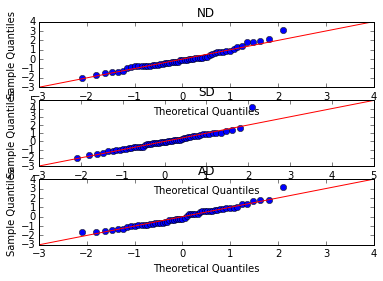

Grand mean: 327.018604194
total sos: 215033.599942 total dof: 164 total variance: 1311.18048745
total_sos: 215033.599942
condition_sos: 80551.4780108
individual_sos: 99090.3959277
remainder_sos: 35391.726004
remainder_variance: 327.701166704 remainder_sos: 35391.726004
total_sos: 215033.599942 condition_sos: 80551.4780108 indiv_sos: 99090.3959277 error (i.e. remainder): 35391.726004

F_cond:122.903862109 P_cond:1.11022302463e-16
F_ind:5.59963624925 P_ind:1.62092561595e-14

Condition:
F(2,108)=122.903862109, p=1.11022302463e-16

Between individuals:
F(54,108)=5.59963624925, p=1.62092561595e-14


Source of var, Sumof Squares, df, Mean square , F ratio         P
-------------------------------------------------------------------
Individual   , 99090.3959277, 54, 1835.00733199, 5.59963624925, 1.62092561595e-14
Condition    , 80551.4780108, 2, 40275.7390054, 122.903862109, 1.11022302463e-16
Remainder    , 35391.726004, 108, 327.701166704, -, -
Total        , 215033.599942, 164, -, -, -


In [27]:
from __future__ import division
# This repmeasures_anova works on the mean latency for each individual.
# This is effectively a "two factor anova without replication"
import numpy as np

def repmeasures_anova(individuals):

    # A one-way repeated measures anova is computed like a "two-factor anova without replication"
    # for a random block design. That means sums of squares are computed like a two factor anova.
    # This example follows McKillup Section 15.5 (p216).

    # Containers to fill
    nodist_latencies = [];
    sync_latencies = [];
    async_latencies = [];

    num_individuals = len(individuals)
    num_conditions = 3
    
    # Zeroth, exclude outliers (assumed already to have been done before this method was called)

    # In this loop extract the latencies into external containers:
    for i,ind in individuals.iteritems():
        # NB: Assume here that any outlier excluding has ALREADY been carried out.
        nodist_latencies = np.concatenate((nodist_latencies, [ind.nodist_mean()]))
        sync_latencies = np.concatenate((sync_latencies, [ind.sync_mean()]))
        async_latencies = np.concatenate((async_latencies, [ind.async_mean()]))

    # Compute grand mean
    all_latencies = np.concatenate((nodist_latencies, sync_latencies, async_latencies))
    grand_mean = all_latencies.mean()
    print 'Grand mean:',grand_mean
    
    # Displacement due to ALL sources of variation in the experiment. Factor A, Factor B, interaction, error.
    # total_variance. This is displacement from the grand mean.
    total_sos = 0
    total_dof = -1 # dof is number of replicates -1
    for i in individuals:
        ind = individuals[i]
        total_sos += np.power(grand_mean - ind.nodist_mean(), 2)
        total_sos += np.power(grand_mean - ind.sync_mean(), 2)
        total_sos += np.power(grand_mean - ind.async_mean(), 2)
    
    total_dof = (num_conditions*num_individuals)-1

    # So here's the total variance:
    total_variance = total_sos/total_dof
    print 'total sos:',total_sos,'total dof:',total_dof,'total variance:',total_variance
    # Could also get total sos with:
    # total_variance = all_latencies.var(ddof=1) # but it doesn't work as above.

    # Now consider the data in relation to each of the two factors (individual and condition)
    
    # Compute condition_plus_error_sos (Factor A - equiv to Temperature in p177 of McKillup)
    nd_treatment_mean = 0
    sd_treatment_mean = 0
    ad_treatment_mean = 0

    for i,ind in individuals.iteritems():
        nd_treatment_mean += ind.nodist_mean()
        sd_treatment_mean += ind.sync_mean()
        ad_treatment_mean += ind.async_mean()

    nd_treatment_mean = nd_treatment_mean / num_individuals
    sd_treatment_mean = sd_treatment_mean / num_individuals
    ad_treatment_mean = ad_treatment_mean / num_individuals
    
    # Now we have treatment means for each condition.
    
    condition_sos = num_individuals*(np.power(nd_treatment_mean - grand_mean,2) + np.power(sd_treatment_mean - grand_mean,2) + np.power(ad_treatment_mean - grand_mean,2))
    condition_dof = num_conditions-1 # 3 conditions - 1 = 2
    
    condition_variance = condition_sos / condition_dof
    
    # Compute individual_plus_error_sos (p178).
    individual_sos = 0
    for i,ind in individuals.iteritems():
        ind_mean = (ind.nodist_mean() + ind.sync_mean() + ind.async_mean()) / 3
        individual_sos += num_conditions*np.power(ind_mean-grand_mean,2)
    individual_dof = (num_individuals-1)
    
    individual_variance = individual_sos / individual_dof
    
    # remainder variance computed by subtraction
    ##remainder_variance = total_variance - condition_variance - individual_variance
    remainder_sos = total_sos - condition_sos - individual_sos
    print 'total_sos:', total_sos
    print 'condition_sos:', condition_sos
    print 'individual_sos:', individual_sos
    print 'remainder_sos:', remainder_sos
    remainder_dof = total_dof - condition_dof - individual_dof
    # This is the best estimate for error in a two factor ANOVA without replication:
    remainder_variance = remainder_sos/remainder_dof
    print 'remainder_variance:',remainder_variance,'remainder_sos:',remainder_sos
    
    print 'total_sos:',total_sos,'condition_sos:',condition_sos,'indiv_sos:',individual_sos,'error (i.e. remainder):',remainder_sos

    
    # Now compute the F ratios
    F_cond = condition_variance / remainder_variance # fixed. condition + error
    F_ind = individual_variance / remainder_variance # random. individual + error
    
    # Lastly, what's the probability for this?
    P_cond = 1-special.fdtr(condition_dof,remainder_dof,F_cond)
    P_ind = 1-special.fdtr(individual_dof,remainder_dof,F_ind)
    
    print '\nF_cond:{0} P_cond:{1}'.format(F_cond,P_cond)
    print 'F_ind:{0} P_ind:{1}'.format(F_ind,P_ind)
    #print 'F_interaction:{0} P_interaction:{1}'.format(F_interaction,P_interaction)
    
    print '\nCondition:\nF({0},{1})={2}, p={3}'.format(condition_dof,remainder_dof,F_cond,P_cond)
    print '\nBetween individuals:\nF({0},{1})={2}, p={3}'.format(individual_dof,remainder_dof,F_ind,P_ind)
    
    print '\n'
    print 'Source of var, Sumof Squares, df, Mean square , F ratio        ','P'
    print '-------------------------------------------------------------------'
    print '{0}, {1}, {2}, {3}, {4}, {5}'.format('Individual   ',individual_sos,individual_dof,individual_variance,F_ind,P_ind)
    print '{0}, {1}, {2}, {3}, {4}, {5}'.format('Condition    ',condition_sos,condition_dof,condition_variance,F_cond,P_cond)
    print '{0}, {1}, {2}, {3}, {4}, {5}'.format('Remainder    ',remainder_sos,remainder_dof,remainder_variance,'-','-')
    print '{0}, {1}, {2}, {3}, {4}, {5}'.format('Total        ',total_sos,total_dof,'-','-','-')

def normality_test(individuals):
    print '\nNormality of data:'

    nd_latency_means = []
    sd_latency_means = []
    ad_latency_means = []
    for i,ind in individuals.iteritems():
        nd_latency_means = np.append(nd_latency_means, ind.nodist_mean())
        sd_latency_means = np.append(sd_latency_means, ind.sync_mean())
        ad_latency_means = np.append(ad_latency_means, ind.async_mean())

    print ' Shapiro-Wilks:'
    W, p = stats.shapiro (subsample(nd_latency_means, 25))
    print ' No Distractor, 25 sub-samples: W',W,'p-value',p,'(Reject Normal NULL hypothesis if p<alpha=0.05)'
    W, p = stats.shapiro (subsample(sd_latency_means, 25))
    print ' Sync Distractor, 25 sub-samples: W',W,'p-value',p
    W, p = stats.shapiro (subsample(ad_latency_means, 25))
    print ' Async Distractor, 25 sub-samples: W',W,'p-value',p

    print '\nSee also QQ Plots (set show_graph to 1)'
    # Quantile-Quantile Plot to show normality
    show_graph = 1
    if show_graph==1:
        %matplotlib inline
        f, (ax1, ax2, ax3) = plt.subplots(3)
        fig1 = sm.qqplot(nd_latency_means, fit=True, line='45',ax=ax1)
        ax1.set_title('ND')
        fig2 = sm.qqplot(sd_latency_means, fit=True, line='45',ax=ax2)
        ax2.set_title('SD')
        fig3 = sm.qqplot(ad_latency_means, fit=True, line='45', ax=ax3)
        ax3.set_title('AD')
        savename = 'images/latency_means_normplot.png'
        plt.savefig(savename)
        plt.show()

# Call the repeated measures ANOVA
individuals = readIndividuals()

# Could equalise replicants, but this would be entirely optional for repeated measures as the latencies are averaged.
#individuals = equaliseReplicates(individuals)
# If we don't call equalise, then must exclude outliers anyway:
for i,ind in individuals.iteritems():
    ind.excludeOutliers()

normality_test(individuals)

repmeasures_anova(individuals)

### Repeated measures ANOVA summary

The null hypotheses are that "condition does not change latency" and
"individual does not affect latency".

A repeated measures anova, where I use the mean latency for each
condition as a single data point for each individual shows a
significant effect both for condition and for individual - the null
hypotheses would be rejected in each case if the data fulfilled normality.

## Output data for analysis in R

How many different stats systems can we use for one piece of data
analysis? See various .r scripts which carry out much of the analysis reported in the paper.

This code block generates AnovaR.csv which contains the latencies and
error_rates.csv which contains the error rates.

In [9]:
# Output data in format suitable for R
individuals = readIndividuals()

# Optional:
#individuals = equaliseReplicates(individuals)
# or
# If we don't call equalise, exclude outliers anyway:
for i,ind in individuals.iteritems():
    ind.excludeOutliers()

async_lines = 'subj_id,num,type,error,correctmove,latency,omit,oreas,timesincelast,direction,destination\n'
sync_lines = 'subj_id,num,type,error,correctmove,latency,omit,direction\n'
nodist_lines = 'subj_id,num,type,error,correctmove,latency,omit,direction\n'
csvdata = 'idnum,latency,condition,condition_str,subj_id\n'
csvtrialdata = 'subj_id,latency,condition_str\n'
for i,ind in individuals.iteritems():
    csvdata += ind.outputDataForR()
    # Save this particular individuals latency values
    csvtrialdata += ind.writeDataForR()
    async_lines += ind.writeAsyncDataForR()
    sync_lines += ind.writeSyncDataForR()
    nodist_lines += ind.writeNoDistDataForR()

print 'Writing AnovaR.csv...'
f = open('AnovaR.csv', 'w')
f.write(csvdata)
f.close()

print 'Writing AllTrials.csv...'
f = open('AllTrials.csv', 'w')
f.write(csvtrialdata)
f.close()

print 'Writing AsyncTrials.csv...'
f = open('AsyncTrials.csv', 'w')
f.write(async_lines)
f.close()

print 'Writing SyncTrials.csv...'
f = open('SyncTrials.csv', 'w')
f.write(sync_lines)
f.close()

print 'Writing NoDistTrials.csv...'
f = open('NoDistTrials.csv', 'w')
f.write(nodist_lines)
f.close()

print 'Writing error_rates.csv...'
f = open('error_rates.csv', 'w')
f.write ('idnum,error_rate,condition,condition_str,subj_id\n')
for i,ind in readIndividuals().iteritems():
    subj_id = ind.subj_id
    if subj_id == 'NA':
        subj_id = 'NA_'
    f.write ('{0},{1},1,ND,{2}\n'.format(ind.idnum,ind.num_moveerrors_per_target(0),subj_id))
    f.write ('{0},{1},2,SD,{2}\n'.format(ind.idnum,ind.num_moveerrors_per_target(1),subj_id))
    f.write ('{0},{1},3,AD,{2}\n'.format(ind.idnum,ind.num_moveerrors_per_target(2),subj_id))
f.close()


Writing AnovaR.csv...
Writing AllTrials.csv...
Writing AsyncTrials.csv...
Writing SyncTrials.csv...
Writing NoDistTrials.csv...
Writing error_rates.csv...


## ANOVA on latency ranks
This code block calls the R script **RankedAnova.r** and outputs the result. It means you have to have R installed (version 3.0.2 will match my system) with the packages nlme and effsize.

In [29]:
from subprocess import CalledProcessError, check_output
try:
    out = check_output(["R", "-q --file=RankedAnova.r"])
except CalledProcessError as err:
    print 'Error for:',err.cmd,'with error code:',err.returncode
    print "\nOutput:\n\n",err.output
else:
    for line in out.splitlines():
        print line

> # I found guidance on Anovas in R here:
> # https://gribblelab.wordpress.com/2009/03/09/repeated-measures-anova-using-r/
> # and here:
> # https://seriousstats.wordpress.com/tag/rank-transformation/
> 
> # Set factor contrasts option, important for aov() function.
> options(contrasts=c("contr.treatment","contr.treatment"))
> 
> latdat <- read.csv('AnovaR.csv')
> 
> # Using Linear Mixed Effects models
> require(nlme)
> 
> # Compute ranks to carry out ANOVA on the ranks
> rlatency <- rank(latdat$latency)
> #
> # The formulae here are:
> # fixed: rlatency "is predicted by" condition_str
> # random: "is predicted by" "the mean" "given" "condition_str nested within subj_id"
> anova_ranked_cond <- lme(fixed = rlatency ~ condition_str, random = ~1|subj_id/condition_str, data=latdat)
> # ------------------------------------------------------------------------------
> print (summary(anova_ranked_cond))
Linear mixed-effects model fit by REML
 Data: latdat 
       AIC      BIC    logLik
  1598.

Residuals (Condition):


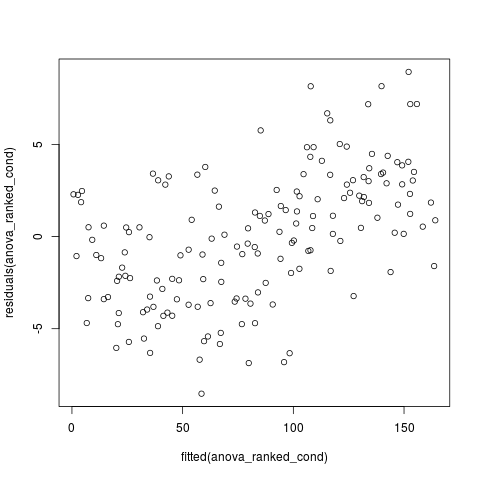

In [30]:
print 'Residuals (Condition):'
Image(filename='r_images/anova_ranked_cond_resid.png')

Residuals (Individual)


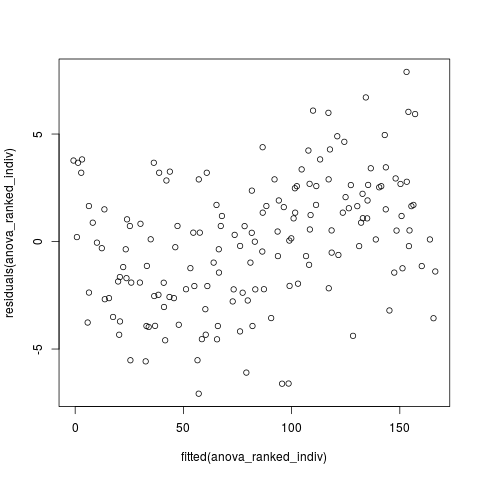

In [31]:
print 'Residuals (Individual)'
Image(filename='r_images/anova_ranked_indiv_resid.png')

## Individual analysis of latencies

Now run **Bootstrap_indiv.r** to compute per-individual results.

In [32]:
from subprocess import CalledProcessError, check_output
try:
    out = check_output(["R", "-q --file=Bootstrap_indiv.r"])
except CalledProcessError as err:
    print 'Error for:',err.cmd,'with error code:',err.returncode
    print "\nOutput:\n\n",err.output
else:
    for line in out.splitlines():
        #if line[0] != ">" and line[0] != "+":
            print line

> # Here, I'm going to bootstrap the latencies of each individual
> 
> set.seed(19742016)
> 
> # This loads individual latencies. each file contains two columns,
> # latency and condition_str. The latencies are all from non-error
> # events.
> fns <- list.files(pattern="IndDat*")
> 
> fasterSlower <- c()
> 
> sdadNoDiff<-0
> adFaster<-1
> sdFaster<-2
> 
> ndall <- c()
> sdall <- c()
> adall <- c()
> for (indiv in fns) {
+ 
+     latdat <- read.csv(indiv)
+ 
+     # Extract latencies for the three conditions
+     nd <- latdat[latdat$condition_str == "ND",]$latency
+     sd <- latdat[latdat$condition_str == "SD",]$latency
+     ad <- latdat[latdat$condition_str == "AD",]$latency
+ 
+     # Make vectors of all the latencies together, for all individuals
+     ndall <-c(ndall, nd)
+     sdall <-c(sdall, sd)
+     adall <-c(adall, ad)
+ 
+     lat.n <- 1000
+ 
+     # Plot will show that 87% of the possible means that I could have
+     # measured for SD and AD were different with
+     la

An example individual set of latency bootstrap means


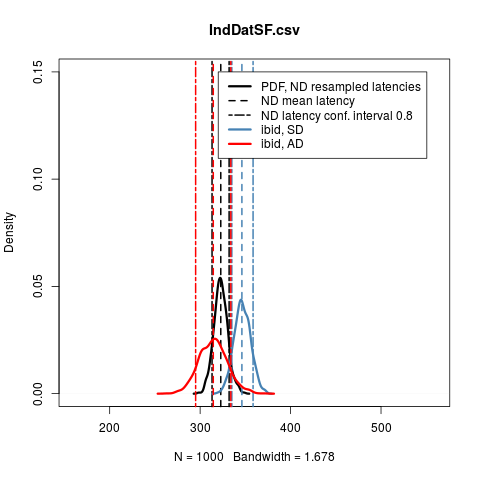

In [33]:
print 'An example individual set of latency bootstrap means'
Image(filename='r_images/bootstrap_indiv_IndDatSF.csv.png')

## Bootstrap analysis of latencies

After calling **Bootstrap_indiv.r**, **Bootstrap_all.r** can be called.

In [10]:
from subprocess import CalledProcessError, check_output
try:
    out = check_output(["R", "-q --file=Bootstrap_all.r"])
except CalledProcessError as err:
    print 'Error for:',err.cmd,'with error code:',err.returncode
    print "\nOutput:\n\n",err.output
else:
    print 'Success'
    #for line in out.splitlines():
    #    print line

Success


Latency measurement distributions, all subjects


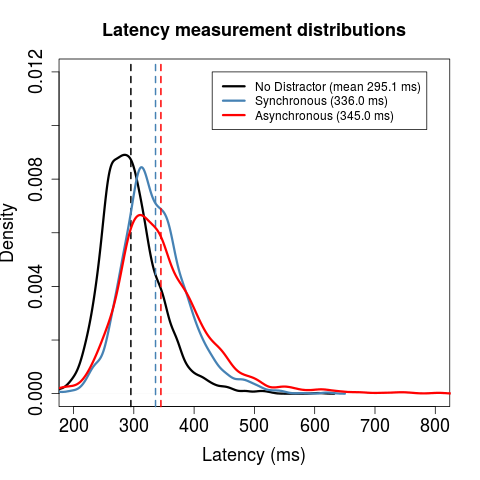

In [8]:
print 'Latency measurement distributions, all subjects'
Image(filename='r_images/data_density.png')

Bootstrapped latency means, all subjects


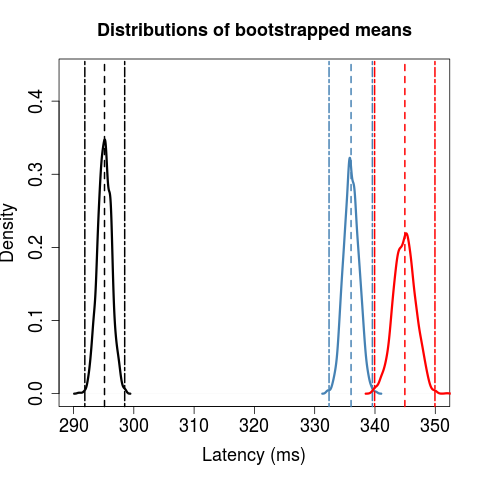

In [9]:
print 'Bootstrapped latency means, all subjects'
Image(filename='r_images/bootstrapped_means.png')

Means again, this time with 95% confidence intervals as error bars


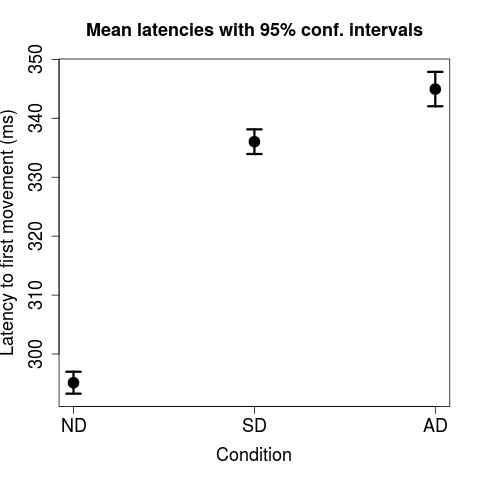

In [11]:
print 'Means again, this time with 95% confidence intervals as error bars'
Image(filename='r_images/meanmad.png')

## Analysis of Movement Errors

It's possible to count the number of errors which the subject makes
when following the target. In some trials, the subject will mistakenly
begin to move towards the distractor line, before correcting
(sometimes after a very short period of time) to move towards the
target. I wanted to see whether the synchronous distractor or the
asynchronous distractor produce more errors, but it is hard to
compare. In the synchronous distractor condition, there are always the same
number of distractor events as target events. In the asynchronous
distractor condition, there may be more distractor events (or fewer) than
target events. I concluded that it's not possible to compare SD and AD
conditions.

### Overall and Group-based movement error analysis

This R code block computes mean error rates and their MAD and StDev
statistics, and it also then computes Wilcoxon signed rank test and
Cliff's Delta for the ND and SD error rates. There is a bootstrap
analysis of the error rates and then, in the same file, a bootstrap
analysis of the fasterSync/fasterAsync sub-groups.

In [47]:
from subprocess import CalledProcessError, check_output
try:
    out = check_output(["R", "-q --file=Err.r"])
except CalledProcessError as err:
    print 'Error for:',err.cmd,'with error code:',err.returncode
    print "\nOutput:\n\n",err.output
else:
    print 'Success'
    #for line in out.splitlines():
    #    print line

Success


Bootstrapped error means


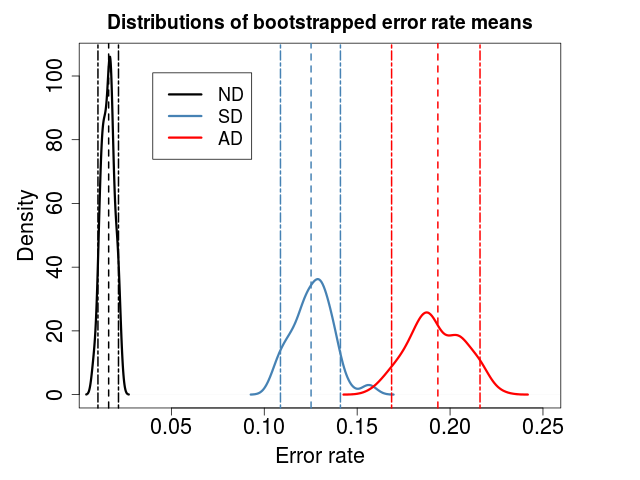

In [48]:
print 'Bootstrapped error means'
Image(filename='r_images/bootstrap_errors.png')

In [43]:
from subprocess import CalledProcessError, check_output
try:
    out = check_output(["R", "-q --file=Bootstrap_async.r"])
except CalledProcessError as err:
    print 'Error for:',err.cmd,'with error code:',err.returncode
    print "\nOutput:\n\n",err.output
else:
    for line in out.splitlines():
        print line

Error for: ['R', '-q --file=Bootstrap_async.r'] with error code: 1

Output:

> #
> # Analysis of Async-specific statistics. Especially:
> #
> # 1) Does last event recency affect latency of distrator movements? (Ans: No)
> # 2) Does distractor recency affect latency of target movements? (Ans: No)
> # 3) Does distractor in same direction as target reduce latency?
> # 4) What's the reaction time for distractors cf. targets?
> #
> 
> maxlatency <- 1000
> 
> # a function which will bootstrap the standard error of the mean
> bs.mean <- function(data, num) {
+     resamples <- lapply(1:num, function(i) sample(data, replace=T))
+     r.mean <- sapply(resamples, mean)
+     std.err <- sqrt(var(r.mean))
+     list(std.err=std.err, resamples=resamples, means=r.mean)
+ }
> bs.median <- function(data, num) {
+     resamples <- lapply(1:num, function(i) sample(data, replace=T))
+     r.median <- sapply(resamples, median)
+     std.err <- sqrt(var(r.median))
+     list(std.err=std.err, resamples=resa

1) Does last event recency affect latency of DISTRACTOR movements? ANS: No.
Raw distractor latency vs. time-since-last-event:


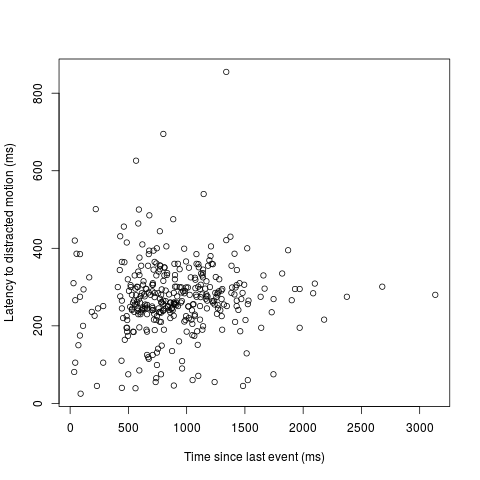

In [41]:
print '1) Does last event recency affect latency of DISTRACTOR movements? ANS: No.'
print 'Raw distractor latency vs. time-since-last-event:'
Image(filename='r_images/async_dist_timesince_vs_latency.png')

Binned median latencies


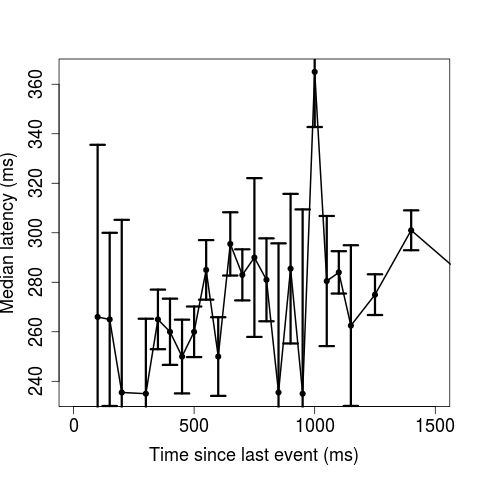

In [42]:
print 'Binned median latencies'
Image(filename='./r_images/async_dist_binned_latencies.png')

2) Does last event recency affect latency of TARGET movements? ANS: No.
Raw target latency vs. time-since-last-event:


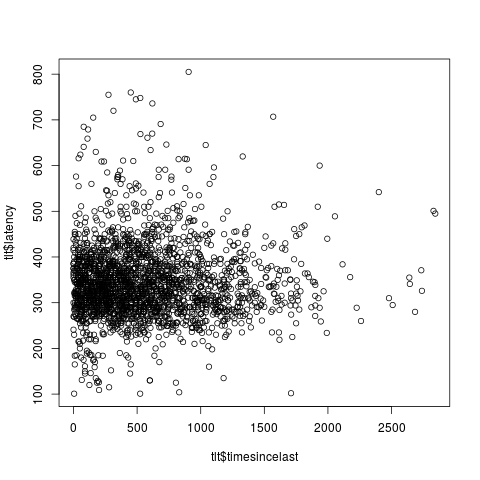

In [43]:
print '2) Does last event recency affect latency of TARGET movements? ANS: No.'
print 'Raw target latency vs. time-since-last-event:'
Image(filename='r_images/async_targ_timesince_vs_latency.png')

Binned median latencies


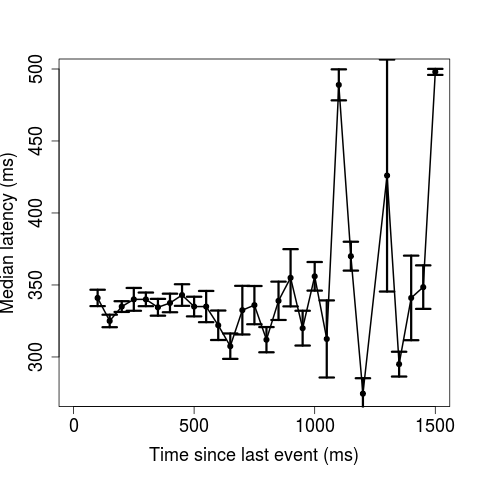

In [44]:
print 'Binned median latencies'
Image(filename='./r_images/async_targ_binned_latencies.png')

3) Does distractor in same direction as target reduce latency? ANS: No (not significantly)
Here "distractor opposite" means:
"the existing distractor location was in the opposite direction compared with the new target location"
Can say that: There's 0.7921 probability that lat_dist_same > lat_dist_opp; 0.1958 
probability that lat_dist_same is not determinedly > or < lat_dist_opp. Finally, 
there's 0.0121 probability that lat_dist_same < lat_dist_opp.


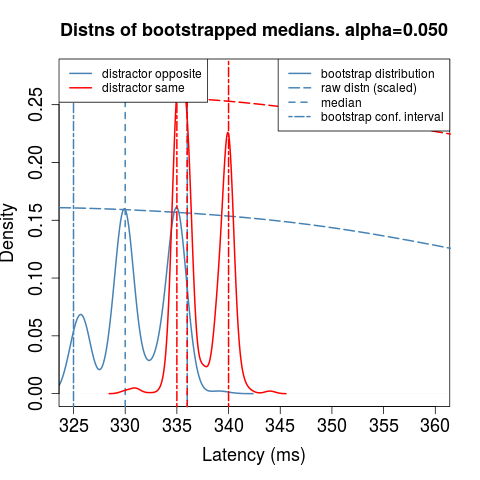

In [45]:
print '3) Does distractor in same direction as target reduce latency? ANS: No (not significantly)'
print 'Here "distractor opposite" means:\n"the existing distractor location was in the opposite direction compared with the new target location"'
print "Can say that: There's 0.7921 probability that lat_dist_same > lat_dist_opp; 0.1958 "
print "probability that lat_dist_same is not determinedly > or < lat_dist_opp. Finally, "
print "there's 0.0121 probability that lat_dist_same < lat_dist_opp." 
Image(filename='./r_images/async_targ_vs_oppositeness_of_distractor.png')

4) What's the reaction time for distractors cf. targets *within the AD condition*?
ANS: Significantly different.


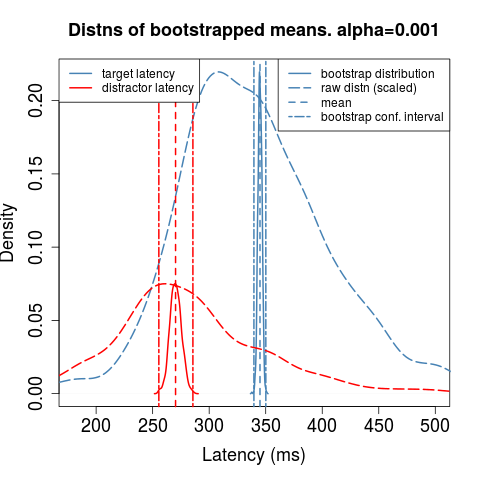

In [10]:
print '4) What\'s the reaction time for distractors cf. targets *within the AD condition*?\nANS: Significantly different.'
Image(filename='./r_images/async_targ_vs_dist.png')

5) What's the reaction time for distractors cf. targets *within the SD condition*?


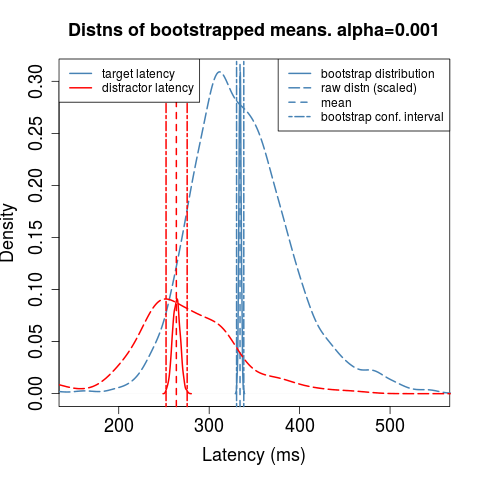

In [11]:
print '5) What\'s the reaction time for distractors cf. targets *within the SD condition*?'
Image(filename='./r_images/sync_targ_vs_dist.png')

6) What's the reaction time for error moves cf. correct, target movements *within the ND condition*?


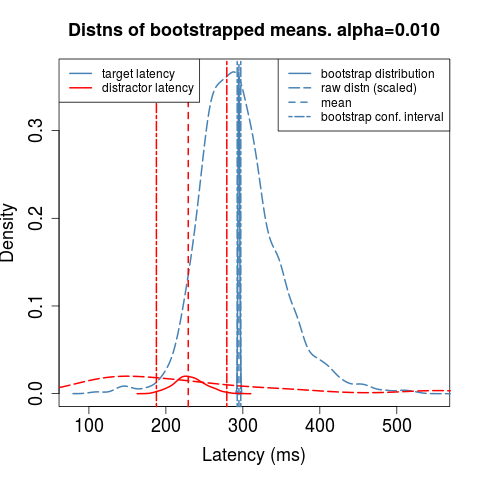

In [3]:
print '6) What\'s the reaction time for error moves cf. correct, target movements *within the ND condition*?'
Image(filename='./r_images/nodist_targ_vs_dist.png')

# Alternative movement analysis

Mauro da Lio developed an alternative approach to finding movement
latencies and errors from the raw position data; an alternative to the
Octave script which creates fnames.mat. Here are scripts to load in
the Summary.csv that is provided by his analysis, and also a code
block to re-create an equivalent Summary.csv file from the
Octave-generated data.

## Reading data 

To read data in for the alternative movement analysis, replace calls
to readIndividuals() in the code blocks above with this alternative
function readMauroIndividuals().

(I convert Summary.xls into Summary.csv before running this code.)

In [48]:
# This function reads in data from Mauro's Summary.csv, producing the same list of individuals
# as is generated by readIndividuals()
import csv
def readMauroIndividuals ():
    with open('Mauro_analysis/Summary.csv', 'rb') as csvfile:
        
        individuals = dict()
        idnum_counter = 1
        first = 1
        dreader = csv.reader(csvfile, delimiter=',', quotechar='"')
        
        for row in dreader:
            
            # Skip first row (the header)
            if first:
                first = 0
                continue

            # Can access rows by column number:
            #print row[3]
            #print row
            #print len(row)
            #break
            
            subj_id = row[1]
            exp_name = row[0]

            # condition index is for the no distractor/sync distractor/async distractor
            condition_index = int(row[2])

            # Need ONE individual object for each subj_id.
            if subj_id not in individuals:
                individuals[subj_id] = individual(subj_id)
                individuals[subj_id].idnum = idnum_counter
                individuals[subj_id].numSubsamples = 8
                idnum_counter += 1

            # No filename in Mauro's csv, just put name in each:
            individuals[subj_id].filename_nd = exp_name
            individuals[subj_id].filename_ad = exp_name
            individuals[subj_id].filename_sd = exp_name

            #individuals[subj_id].alldata_nd=np.ndarray(5)

            # latencies for non-movement-error target events
            ##tnoerr_latencies = fname[4] # R.latency_noerror_target - Use table with python index 4 - "no move error", "target event".
            # latencies for non-movement-error distractor events
            ##dnoerr_latencies = fname[5]
            # err_latencies = fname[6] # ALL error events, distractor and target.
            # latencies for target movement error events
            ##terr_latencies = fname[7] # R.latency_error_target
            # latencies for distractor movement error events
            ##derr_latencies = fname[8] # R.latency_error_distractor
            if condition_index == 0:
                i=10 # starting col for the latencies in Mauro's spreadsheet
                while i < len(row):
                    if len(row[i]) == 0:
                       break
                    rowval = float(row[i])
                    # New latency:
                    newlat = np.array([i+1,rowval])
                    if (rowval >= 0):
                        # number, type (TARG=1 here), error, correct_move, latency
                        newalldata = np.array([i+1, 1, 0, 1, rowval])
                        if individuals[subj_id].nodist_latencies.size == 0:
                            individuals[subj_id].nodist_latencies = newlat
                        else:
                            individuals[subj_id].nodist_latencies = np.vstack((individuals[subj_id].nodist_latencies, newlat))
                    else:
                        newalldata = np.array([i+1, 1, 1, 0, rowval])
                        if individuals[subj_id].nodist_err_latencies.size == 0:
                            individuals[subj_id].nodist_err_latencies = -1*newlat
                        else:
                            individuals[subj_id].nodist_err_latencies = np.vstack((individuals[subj_id].nodist_err_latencies, -1*newlat))

                    if individuals[subj_id].alldata_nd.size == 0:
                        individuals[subj_id].alldata_nd = newalldata
                    else:
                        individuals[subj_id].alldata_nd = np.vstack((individuals[subj_id].alldata_nd, newalldata))

                    #print 'alldata',individuals[subj_id].alldata_nd
                    i+=1
                # Compute ranks
                #print 'nodist latencies:',individuals[subj_id].nodist_latencies
                #print 'nodist_err latencies:',individuals[subj_id].nodist_err_latencies
                if individuals[subj_id].nodist_latencies.size>0:
                   individuals[subj_id].nodist_latencies_rank = stats.rankdata(individuals[subj_id].nodist_latencies[:,1])
                if individuals[subj_id].nodist_err_latencies.size>0:
                    if individuals[subj_id].nodist_err_latencies.size==2:
                        individuals[subj_id].nodist_err_latencies_rank = [1]
                    else:
                        individuals[subj_id].nodist_err_latencies_rank = stats.rankdata(individuals[subj_id].nodist_err_latencies[:,1])
                
                # nerrs code identical to that in readIndividuals
                nerrs = 0
                ntargets = 0
                for d in individuals[subj_id].alldata_nd:
                    ntargets += 1 # "ndistractors" is really "ntargets" for the ND condition.
                    if d[2] > 0.0:
                        nerrs += 1
                individuals[subj_id].n_errors_per_target_nd = (float(nerrs) / float(ntargets))
                #print individuals[subj_id].n_errors_per_target_nd 

            if condition_index == 1:
                i=10 # starting col for the latencies in Mauro's spreadsheet
                while i < len(row):
                    if len(row[i]) == 0:
                       break
                    rowval = float(row[i])
                    # New latency:
                    newlat = np.array([i+1,rowval])
                    if (rowval >= 0):
                        # number, type (TARG=1 here), error, correct_move, latency
                        newalldata = np.array([i+1, 1, 0, 1, rowval])
                        if individuals[subj_id].sync_latencies.size == 0:
                            individuals[subj_id].sync_latencies = newlat
                        else:
                            individuals[subj_id].sync_latencies = np.vstack((individuals[subj_id].sync_latencies, newlat))
                    else:
                        newalldata = np.array([i+1, 1, 1, 0, rowval])
                        if individuals[subj_id].sync_err_latencies.size == 0:
                            individuals[subj_id].sync_err_latencies = -1*newlat
                        else:
                            individuals[subj_id].sync_err_latencies = np.vstack((individuals[subj_id].sync_err_latencies, -1*newlat))

                    if individuals[subj_id].alldata_sd.size == 0:
                        individuals[subj_id].alldata_sd = newalldata
                    else:
                        individuals[subj_id].alldata_sd = np.vstack((individuals[subj_id].alldata_sd, newalldata))

                    #print 'alldata',individuals[subj_id].alldata_sd
                    i+=1
                #print 'sync latencies:',individuals[subj_id].sync_latencies
                #print 'sync_err latencies:',individuals[subj_id].sync_err_latencies
                # Compute ranks
                if individuals[subj_id].sync_latencies.size>0:
                    individuals[subj_id].sync_latencies_rank = stats.rankdata(individuals[subj_id].sync_latencies[:,1])
                if individuals[subj_id].sync_err_latencies.size>0:
                    if individuals[subj_id].sync_err_latencies.size==2:
                        individuals[subj_id].sync_err_latencies_rank = [1]
                    else:
                        individuals[subj_id].sync_err_latencies_rank = stats.rankdata(individuals[subj_id].sync_err_latencies[:,1])
                
                # nerrs code identical to that in readIndividuals
                nerrs = 0
                ntargets = 0
                for d in individuals[subj_id].alldata_sd:
                    ntargets += 1 # "ndistractors" is really "ntargets" for the ND condition.
                    if d[2] > 0.0:
                        nerrs += 1
                individuals[subj_id].n_errors_per_distractor_sync = (float(nerrs) / float(ntargets))
                #print individuals[subj_id].n_errors_per_distractor_sync 

            if condition_index == 2:
                # FIXME: FINISH ME
                i=10 # starting col for the latencies in Mauro's spreadsheet
                while i < len(row):
                    if len(row[i]) == 0:
                       break
                    rowval = float(row[i])
                    # New latency:
                    newlat = np.array([i+1,rowval])
                    if (rowval >= 0):
                        # number, type (TARG=1 here), error, correct_move, latency
                        newalldata = np.array([i+1, 1, 0, 1, rowval])
                        if individuals[subj_id].async_latencies.size == 0:
                            individuals[subj_id].async_latencies = newlat
                        else:
                            individuals[subj_id].async_latencies = np.vstack((individuals[subj_id].async_latencies, newlat))
                    else:
                        newalldata = np.array([i+1, 1, 1, 0, rowval])
                        if individuals[subj_id].async_err_latencies.size == 0:
                            individuals[subj_id].async_err_latencies = -1*newlat
                        else:
                            individuals[subj_id].async_err_latencies = np.vstack((individuals[subj_id].async_err_latencies, -1*newlat))

                    if individuals[subj_id].alldata_ad.size == 0:
                        individuals[subj_id].alldata_ad = newalldata
                    else:
                        individuals[subj_id].alldata_ad = np.vstack((individuals[subj_id].alldata_ad, newalldata))

                    #print 'alldata',individuals[subj_id].alldata_ad
                    i+=1
                #print 'async latencies:',individuals[subj_id].async_latencies
                #print 'async_err latencies:',individuals[subj_id].async_err_latencies
                # Compute ranks
                if individuals[subj_id].async_latencies.size>0:
                    individuals[subj_id].async_latencies_rank = stats.rankdata(individuals[subj_id].async_latencies[:,1])
                if individuals[subj_id].async_err_latencies.size>0:
                    if individuals[subj_id].async_err_latencies.size==2:
                        individuals[subj_id].async_err_latencies_rank = [1]
                    else:
                        individuals[subj_id].async_err_latencies_rank = stats.rankdata(individuals[subj_id].async_err_latencies[:,1])
                
                # nerrs code identical to that in readIndividuals
                nerrs = 0
                ntargets = 0
                for d in individuals[subj_id].alldata_ad:
                    ntargets += 1 # "ndistractors" is really "ntargets" for the ND condition.
                    if d[2] > 0.0:
                        nerrs += 1
                individuals[subj_id].n_errors_per_distractor_async = (float(nerrs) / float(ntargets))
                #print individuals[subj_id].n_errors_per_distractor_async 

    return individuals

## Reproduce Summary Spreadsheet for comparison with Mauro's analysis
Mauro has Summary.xls, which lists the following columns:

Experimenter    Subject    Distractor type    RT (M)    RT (SD)    N correct    RT incorrect (M)    RT incorrect (SD)    N incorrect    Error rate    Delays (negative = incorrect)

The following code creates an equivalent Summary.csv from the data in
fnames.dat.

In [49]:
from __future__ import division
import numpy as np
from statsmodels.stats.multicomp import MultiComparison

maxCount = 100 # 1 for debug or 100 for all
count = 1
csvdata = ''

individuals = readIndividuals()

for i in individuals:
    ind = individuals[i]

    if count == 1:
        csvdata = ind.csvheader()
    
    # Remove outliers in standard way
    ind.excludeOutliers()

    csvdata += ind.csvlineset()

    # For debugging, break after maxCount
    if count >= maxCount:
        break
    count += 1

print 'Writing Summary.csv...'
f = open('Summary.csv', 'w')
f.write(csvdata)
f.close()

Writing Summary.csv...
